In [1]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_10749/696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.1
numpy version: 1.21.2


In [3]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [4]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive
# constants for plotting
x_label_elapsedtime = 0
x_label_datetime = 1

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
# Load processed data (phase 1)

dir_path = os.path.join(cwd, 'csv')
filename = 'cell_cycles.pkl'

# load last saved df from phase1 data and convert time stamp and sort
li_ts_cycles_ph1 = data_preprocess.load_object(dir_path, filename)

In [7]:
# Load processed data (phase 2)
dir_path = os.path.join(cwd, 'csv', 'phase_2_pkl')
filename = 'mod1_cell_cycles.pkl'
li_ts_cycles_ph2 = data_preprocess.load_object(dir_path, filename)

In [8]:
# Combine phase1 and phase 2 data
import math

# for x, y in li_ts_cycles_ph1:
#     print('phase1 cells', x, y)
    
# for x, y in li_ts_cycles_ph2:
#     print('phase2 cells', len(y))

combined_phase_cycles = []
if len(li_ts_cycles_ph1) <= len(li_ts_cycles_ph2):
    for i in range(len(li_ts_cycles_ph1)):              # each cell contain multiple cycles
        c_1, cycles_1 = li_ts_cycles_ph1[i]                 # for example, (v1, [cycles])
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        if (c_2 == c_1):
            cycles_1 += cycles_2                        # this adds cycle to li_ts_cycles_ph1
    combined_phase_cycles = li_ts_cycles_ph1
else:
    for i in range(len(li_ts_cycles_ph2)):              # each cell contain multiple cycles
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        c_1, cycles_1 = li_ts_cycles_ph1[i]
        if (c_2 == c_1):
            cycles_2 += cycles_1                        # this adds cycle to li_ts_cycles
    combined_phase_cycles = li_ts_cycles_ph2


for x, y in combined_phase_cycles:
    print('combined cells', x)

combined cells V1
combined cells V2
combined cells V3
combined cells V4
combined cells V5
combined cells V6
combined cells V7
combined cells V8
combined cells V9
combined cells V10
combined cells V11
combined cells V12


In [9]:
import math

# Separate training, validation and test cycles, keep cycles without cell ID
TRAIN_SAMPLES = 0.9
li_train_cycles = []      # each of this list is a separate static_dynamic_static cycle
# li_validation_cycles = []
li_test_cycles= []
counter = 0

total_cycles = 0
for (c, li_cycles) in combined_phase_cycles:              # each cell contain multiple cycles
    counter += 1
    num_cell_cycles = len(li_cycles)
    num_train_cycles = math.floor(num_cell_cycles * TRAIN_SAMPLES)                 # training cycle samples 70%
    # num_validation_cycles = math.ceil((num_cell_cycles - num_train_cycles) * 0.5)
    # num_test_cycles = num_cell_cycles - num_validation_cycles - num_train_cycles
    num_test_cycles = num_cell_cycles - num_train_cycles
    total_cycles += len(li_cycles)
    # print(num_cell_cycles, num_train_cycles, num_validation_cycles, num_test_cycles)

    li_train_cycles += li_cycles[0:num_train_cycles]
    # li_validation_cycles += li_cycles[num_train_cycles:num_train_cycles+num_validation_cycles]
    # li_test_cycles += li_cycles[num_train_cycles+num_validation_cycles:]
    li_test_cycles += li_cycles[num_train_cycles:]
#     if (counter == 7):
#         break
    break

print(total_cycles, len(li_train_cycles), len(li_test_cycles))     # test

17 15 2


In [10]:
# for some cases, model is not .h5 file, in those cases pass model directly as model_path
def get_forecast_list(model_path, np_input, num_forecast, input_window, freeze=False):
    
    if (isinstance(model_path, str)):
        from keras.models import load_model
        model_LSTM_mutivariate = load_model(model_path)
    else:
        model_LSTM_mutivariate = model_path
#     model_LSTM_mutivariate = model
    
    if (np_input.shape[0] < num_forecast):
        num_forecast = np_input.shape[0]

    NUM_INPUT_VARS = np_input.shape[2]
    np_input_copy = np.empty((num_forecast, input_window, NUM_INPUT_VARS), float)
    
    for i in range(num_forecast):
        np_input_copy[i] = np_input[i]      # fill with actual values
        
    # single_input empty array is necessary because LSTM prediction takes input in (num_datapoints, input_window, num_variables) format
    single_input = np.empty((1, input_window, NUM_INPUT_VARS), float)    # single input means 1 data point

    li_predicted = []    
    # predict and append
    for i in range(num_forecast):
        pred_ID = i + input_window    # nth prediction

        single_input[0] = np_input[i]        # whereas np_input[0] is in (input_window, num_variables) format
#         single_input_last_index = single_input.shape[1] - 1      # index where voltage needs to be replaced with predictions
#         print('single_input_last_index: ', single_input_last_index)
#         print(single_input)
        if(len(li_predicted) > 0):
#             print('li_predicted: ', li_predicted)
            for j in range(1, len(li_predicted)+1):
                if(j <= input_window):           # max input_window values to replace, when len(li_predicted) > 0, then all of single input will contain the last 10 vals of predicted
                    _, single_input[0][-j][0] = li_predicted[-j]  # replace from last to first

        predictions = model_LSTM_mutivariate.predict(single_input).flatten()    # flatten returns 1D array
        li_predicted.append((pred_ID, predictions[0]))   # tuple of (id, predicted_value)

    li_rolling_predictoins = []
    for time_id,predict_val in li_predicted:
        li_rolling_predictoins.append(predict_val)

    # Current freezing
    if(freeze):
        FREEZE_DURATION = 15*60    # how many seconds we want to freeze (ex 15 minutes)
        # num_input_samples = np_input.shape[0]
        freeze_start_index = num_forecast - FREEZE_DURATION
        for i in range(freeze_start_index, num_forecast):
            for j in range(input_window):
                np_input_copy[i][j][1] = 0       # asisgn current = 0
        return np_input_copy, li_rolling_predictoins
    else:
        return li_rolling_predictoins


In [11]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X)    #shape = (n, 1) where n= X.shape[0] eg number of data points
    
    # Perform inverse transformation to rescale back to original range
    # Since we used 3 variables for transform, the inverse expects same dimensions
    # Therefore, copy same values 3 times and discard them after inverse transform
    prediction_copies = np.repeat(predictions, X.shape[2], axis=1)   # X.shape[2] is number of variables
    y_pred = scaler.inverse_transform(prediction_copies)[:,0]

    # print(y.shape)   # shape is (n,) e.g. 1D array
    y_actual = np.reshape(y, (y.shape[0], 1))    # make it 2D
    print(y_actual.shape)
    # reverse transform for actuals
    actual_copies = np.repeat(y_actual, X.shape[2], axis=1)   # X.shape[2] is number of variables
    y_actual = scaler.inverse_transform(actual_copies)[:,0]

    df = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_actual})
    df_temp = pd.DataFrame()
    df_temp['counter'] = range(len(y))   # x axis for plot
    custom_plot.plot_dual_axis((df_temp['counter'], "Time"), (df['Predictions'][start:end], "Predicted voltage"), (df['Actuals'], "Actual voltage"))
    print("MSE: ", mse(y, predictions))
    print("RMSE: ", mse(y, predictions, squared=False))
    print("MAE: ", mae(y, predictions))
    print("MAPE: ", mape(y, predictions))

In [12]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

def plot_predictions_multivariate(model, X, y, start=0, end=100):
    predictions = model.predict(X)    #shape = (n, 1) where n= X.shape[0] eg number of data points
    
    # Perform inverse transformation to rescale back to original range
    # Since we used 3 variables for transform, the inverse expects same dimensions
    # Therefore, copy same values 3 times and discard them after inverse transform
#     prediction_copies = np.repeat(predictions, X.shape[2], axis=1)   # X.shape[2] is number of variables
#     y_pred = scaler.inverse_transform(prediction_copies)[:,0]

    # print(y.shape)   # shape is (n,) e.g. 1D array
    y_actual = np.reshape(y, (y.shape[0], 1))    # make it 2D
    print(y_actual.shape)
    # reverse transform for actuals
    actual_copies = np.repeat(y_actual, X.shape[2], axis=1)   # X.shape[2] is number of variables
    y_actual = scaler.inverse_transform(actual_copies)[:,0]

    df = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_actual})
    df_temp = pd.DataFrame()
    df_temp['counter'] = range(len(y))   # x axis for plot
    custom_plot.plot_dual_axis((df_temp['counter'], "Time"), (df['Predictions'][start:end], "Predicted voltage"), (df['Actuals'], "Actual voltage"))
    print("MSE: ", mse(y, predictions))
    print("RMSE: ", mse(y, predictions, squared=False))
    print("MAE: ", mae(y, predictions))
    print("MAPE: ", mape(y, predictions))

In [60]:
print(len(li_train_cycles[2]))


1493


In [13]:
def df_to_supervised_multivariate(df_as_np, input_window, label_index, output_window=1):
    X = []
    y = []
    for i in range(len(df_as_np) - input_window):
        X.append(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
        label = df_as_np[i+input_window][label_index]    # index of output label ie voltage
        y.append(label)
    return np.array(X), np.array(y)
    return X, y

In [24]:
# Constatns
TIMESTEPS = 10
FORECAST_SECONDS = 1100
iteration_no = 0

### univariate single cycle eval

In [50]:
# Make dataset ready for LSTM
# [temporal input sequence] [output]
# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_supervised_univariate(df_feature, df_label, window_size=1):
    df_feature_as_np = df_feature.to_numpy()
    df_label_as_np = df_label.to_numpy()
    X = []
    y = []
    total_rows = len(df_feature_as_np) - window_size + 1
    for i in range(len(df_feature_as_np) - window_size):
        row = [[a] for a in df_feature_as_np[i:i+window_size]]
        X.append(row)
        label = df_label_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [51]:
df_test = li_train_cycles[2].copy()
TIMESTEPS = 3
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

X, y = df_to_supervised_univariate(df_test['current'], df_test['V'], TIMESTEPS)     # prepare sequences for each cycle
print(X.shape, y.shape)

(1424, 3, 1) (1424,)


In [52]:
iteration_no = 4
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM', 'shuffle', 'model' + 'reverse_df' + '.h5')

from keras.models import load_model
model = load_model(model_path)

univar_lstm_predictions = model.predict(X)
univar_lstm_predictions = np.squeeze(univar_lstm_predictions)
print(univar_lstm_predictions.shape)

(1424,)


In [54]:
def multi_scale_plot(*axes):

    # Create figure and subplot manually
    # fig = plt.figure()
    # host = fig.add_subplot(111)

    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

    plt.rc('font', **font)

    # More versatile wrapper
    fig, host = plt.subplots(figsize=(12,5)) # (width, height) in inches
    # (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

    # assign argument values
    title, save_path = axes[0]
    x_data, x_label = axes[1]
    y1_data, y1_label = axes[2]
    y2_data, y2_label = axes[3]
    y3_data, y3_label = axes[4]

    par1 = host.twinx()
    par2 = host.twinx()

    scale_x = 60     # divide by 60 seconds
    li_ticks = np.arange(min(x_data), max(x_data)+1, 60)     # every 60 seconds = 1 minutes freq, assuming 1 Hz sampling rate
    li_labels = list(map(lambda x: int(x/scale_x), li_ticks))      # 60 sec = 1 minutes
    # plt.xticks(li_ticks, li_labels, rotation=45)
    par2.xaxis.set_ticks(li_ticks, li_labels, rotation=45)
    host.set_xlabel('Time (minutes)')

    # Set y axis labels
    host.set_ylabel(y1_label)
    par1.set_ylabel(y2_label)
    par2.set_ylabel(y3_label)

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

    # These labels are in the box
    p1, = host.plot(x_data, y1_data,    color=color1, label=y1_label)
    p2, = par1.plot(x_data, y2_data,    color=color2, label=y2_label)
    p3, = par2.plot(x_data, y3_data, color=color3, label=y3_label)

    lns = [p1, p2, p3]
#     host.legend(handles=lns, loc='lower center')
    host.legend(handles=lns, loc='upper right')

    # right, left, top, bottom
    # par2.spines['right'].set_position(('outward', 60))

    # no x-ticks                 
    # par2.xaxis.set_ticks([])

    # set ticks y axis
    if "Contactor" in y3_label:
        par2.yaxis.set_ticks([0,2,2])        # manually set as contactor state can be either 0 or 2

    # Move "y3 -axis to the left
    par2.spines['left'].set_position(('outward', 60))
    par2.spines['left'].set_visible(True)
    par2.yaxis.set_label_position('left')
    par2.yaxis.set_ticks_position('left')

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    # Best for professional typesetting, e.g. LaTeX
    plt.title(title)
    plt.show()
    plt.savefig(save_path)
    # For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'

In [56]:
%matplotlib notebook
x_axis = np.arange(univar_lstm_predictions.shape[0])
y = y[:FORECAST_SECONDS]
li_current = df_test['current'].to_list()
li_current = li_current[3:]

# show only smaller portion
y = y[1000:]
univar_lstm_predictions = univar_lstm_predictions[1000:]
li_current = li_current[1000:]
x_axis = np.arange(univar_lstm_predictions.shape[0])
print(x_axis)


<IPython.core.display.Javascript object>


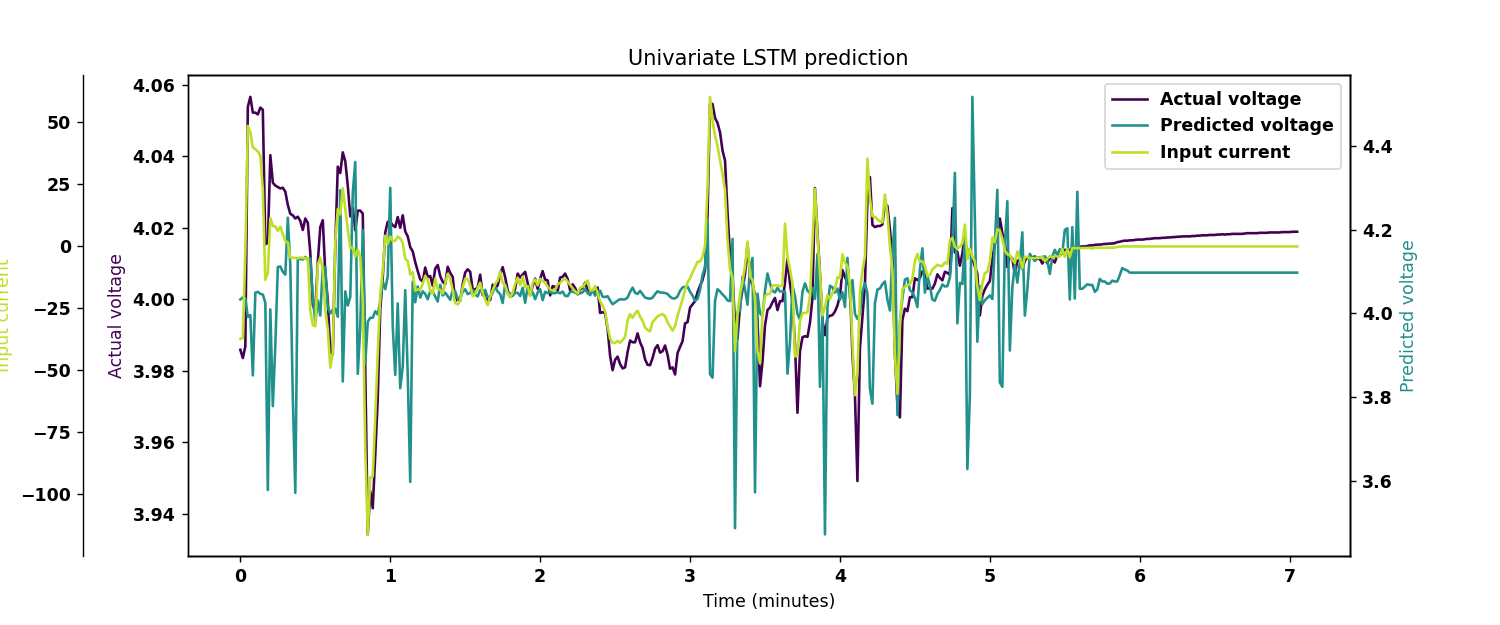

In [57]:
# plot
save_path = os.path.join(cwd, 'generalized', 'LSTM', str('uni') + '.pdf')
# custom_plot.plot_multi_line(("LSTM univar prediction", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (univar_lstm_predictions, "Prediction"), (li_current, "Current"))
multi_scale_plot(("Univariate LSTM prediction", save_path), (x_axis, constants.x_label_elapsedtime), (y, "Actual voltage"), (univar_lstm_predictions, "Predicted voltage"), (li_current, "Input current"))

In [60]:
# MAPE and RMSE

print(mse(univar_lstm_predictions, y, squared=False))
print(mape(univar_lstm_predictions, y))


0.11019672336842068
0.019961507064609908


In [ ]:
# concat same cycle and apply lstm

df_test = li_train_cycles[2].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

### Execute every tiime

In [125]:
df_test = li_train_cycles[6].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test.iloc[1000:1700]    # for clear visibility, take only last few steps

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

In [138]:
# Another cycle
df_test = li_train_cycles[2].copy()
print(len(df_test))
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

# df_test = df_test.iloc[500:]    # for clear visibility, take only last few steps

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y
print(X.shape)

1493
(1417, 10, 3)


In [34]:
import matplotlib
def plot_multi_line(*axes):

    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

    matplotlib.rc('font', **font)
    fig = plt.figure(figsize =(12 ,8))

    # Set line style for different lines, 5 lines max
    li_linestyle = ["-", "--", "-.", ":"]

    # assign argument values
    title, save_path, y_axis_label = axes[0]
    x_data, x_label = axes[1]
    
    # Gather all y axis labels and data
    for i in range(2, len(axes)):
        y_data, y_label = axes[i]
        # print(y_data, y_label)
        plt.plot(x_data, y_data, label = y_label, linestyle=li_linestyle[i-2])

    # X label and Y label
    scale_x = 60     # divide by 60 seconds
    li_ticks = np.arange(min(x_data), max(x_data)+1, 60)     # every 60 seconds = 1 minutes freq
    li_labels = list(map(lambda x: int(x/scale_x), li_ticks))      # 60 sec = 1 minutes
    plt.xticks(li_ticks, li_labels, rotation=45)
    plt.xlabel('Time (minute)')


    plt.title(title) # set the whole plot name
    plt.legend(bbox_to_anchor=(1.0, 1.0),prop={'size': 10,'weight' :'normal'})
    plt.show()
    fig.savefig(save_path)

### Generalized RNN

In [139]:
# 1 step RNN prediction
iteration_no = 0
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'RNN', 'model' + str(iteration_no) + '.h5')

from keras.models import load_model
model = load_model(model_path)

print(X.shape)
rnn_predictions = model.predict(X)
rnn_predictions = np.squeeze(rnn_predictions)
print(rnn_predictions.shape)
x_axis = np.arange(rnn_predictions.shape[0])
y = y[:len(x_axis)]

(1417, 10, 3)
(1417,)


In [105]:
%matplotlib notebook

save_path = os.path.join(cwd, 'generalized', 'RNN', 'model_predict' + str(iteration_no) + '.pdf')
plot_multi_line(("RNN one step ahead prediction", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (rnn_predictions, "Prediction"))

<IPython.core.display.Javascript object>

In [140]:
# LSTM
# 1 step prediction
iteration_no = 1
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(iteration_no) + '.h5')

from keras.models import load_model
model = load_model(model_path)

print(X.shape)
lstm_predictions = model.predict(X)
lstm_predictions = np.squeeze(lstm_predictions)
print(lstm_predictions.shape)

x_axis = np.arange(lstm_predictions.shape[0])
y = y[:len(x_axis)]

(1417, 10, 3)
(1417,)


<IPython.core.display.Javascript object>


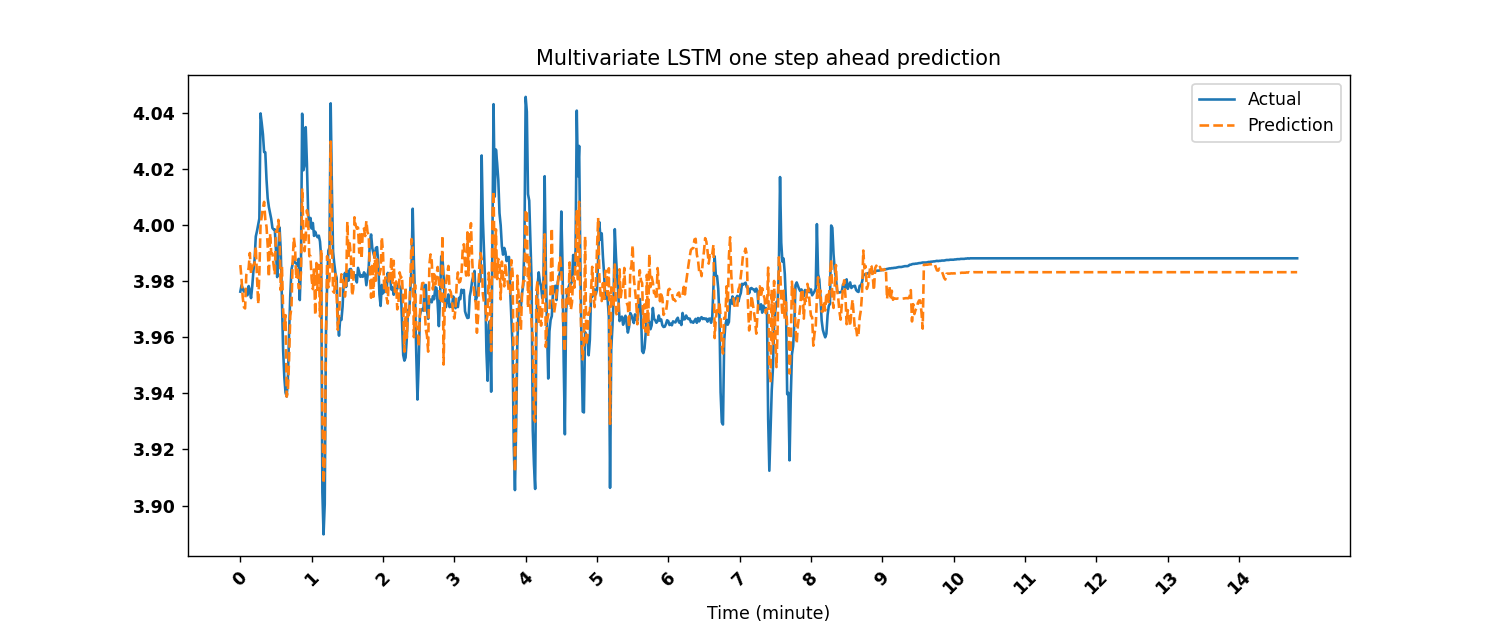

In [102]:
# plot lstm
save_path = os.path.join(cwd, 'generalized', 'LSTM', 'model_predict' + str(iteration_no) + '.pdf')
plot_multi_line(("Multivariate LSTM one step ahead prediction", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (lstm_predictions, "Prediction"))

In [141]:
# LSTM stacked
# 1 step prediction
iteration_no = 1
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'stacked_LSTM', 'model' + str(iteration_no) + '.h5')

from keras.models import load_model
model = load_model(model_path)

print(X.shape)
stacked_predictions = model.predict(X)
stacked_predictions = np.squeeze(stacked_predictions)
print(stacked_predictions.shape)

x_axis = np.arange(stacked_predictions.shape[0])
y = y[:len(x_axis)]

(1417, 10, 3)
(1417,)


<IPython.core.display.Javascript object>


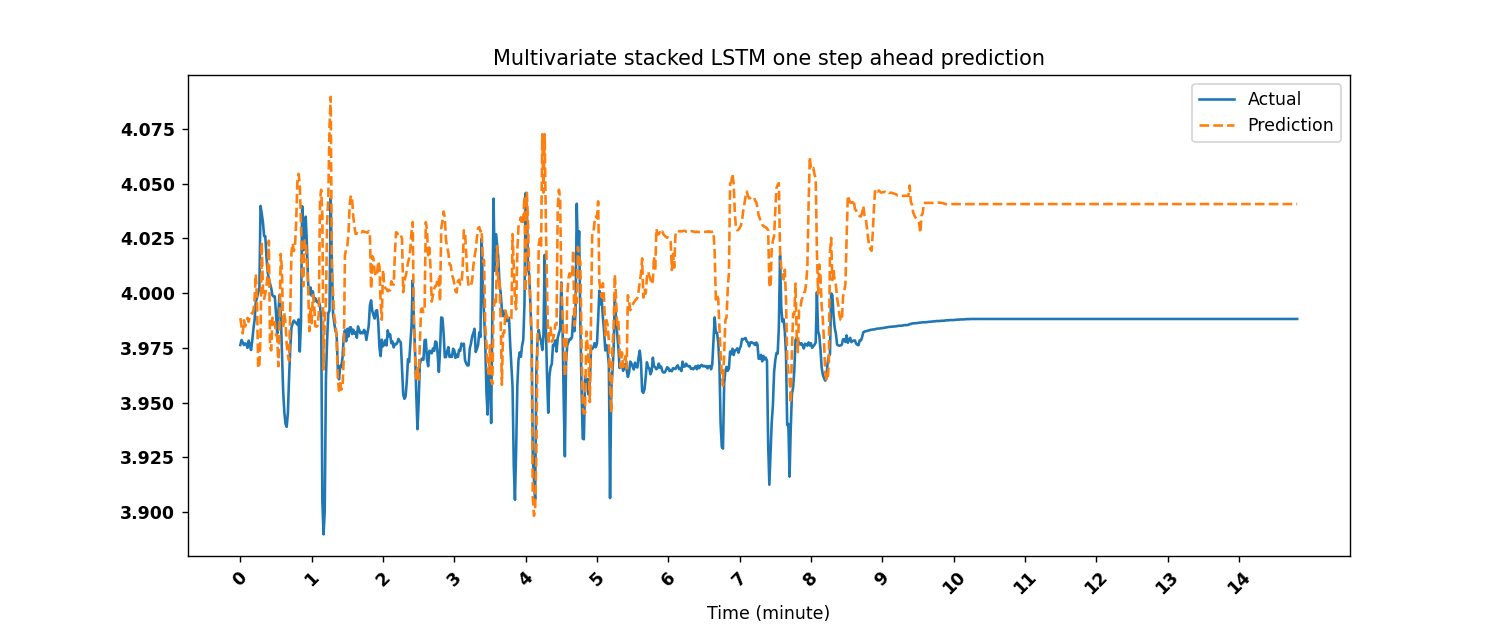

In [107]:
# plot stacked lstm
save_path = os.path.join(cwd, 'generalized', 'stacked_LSTM', 'model_predict' + str(iteration_no) + '.pdf')
plot_multi_line(("Multivariate stacked LSTM one step ahead prediction", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (stacked_predictions, "Prediction"))

<IPython.core.display.Javascript object>


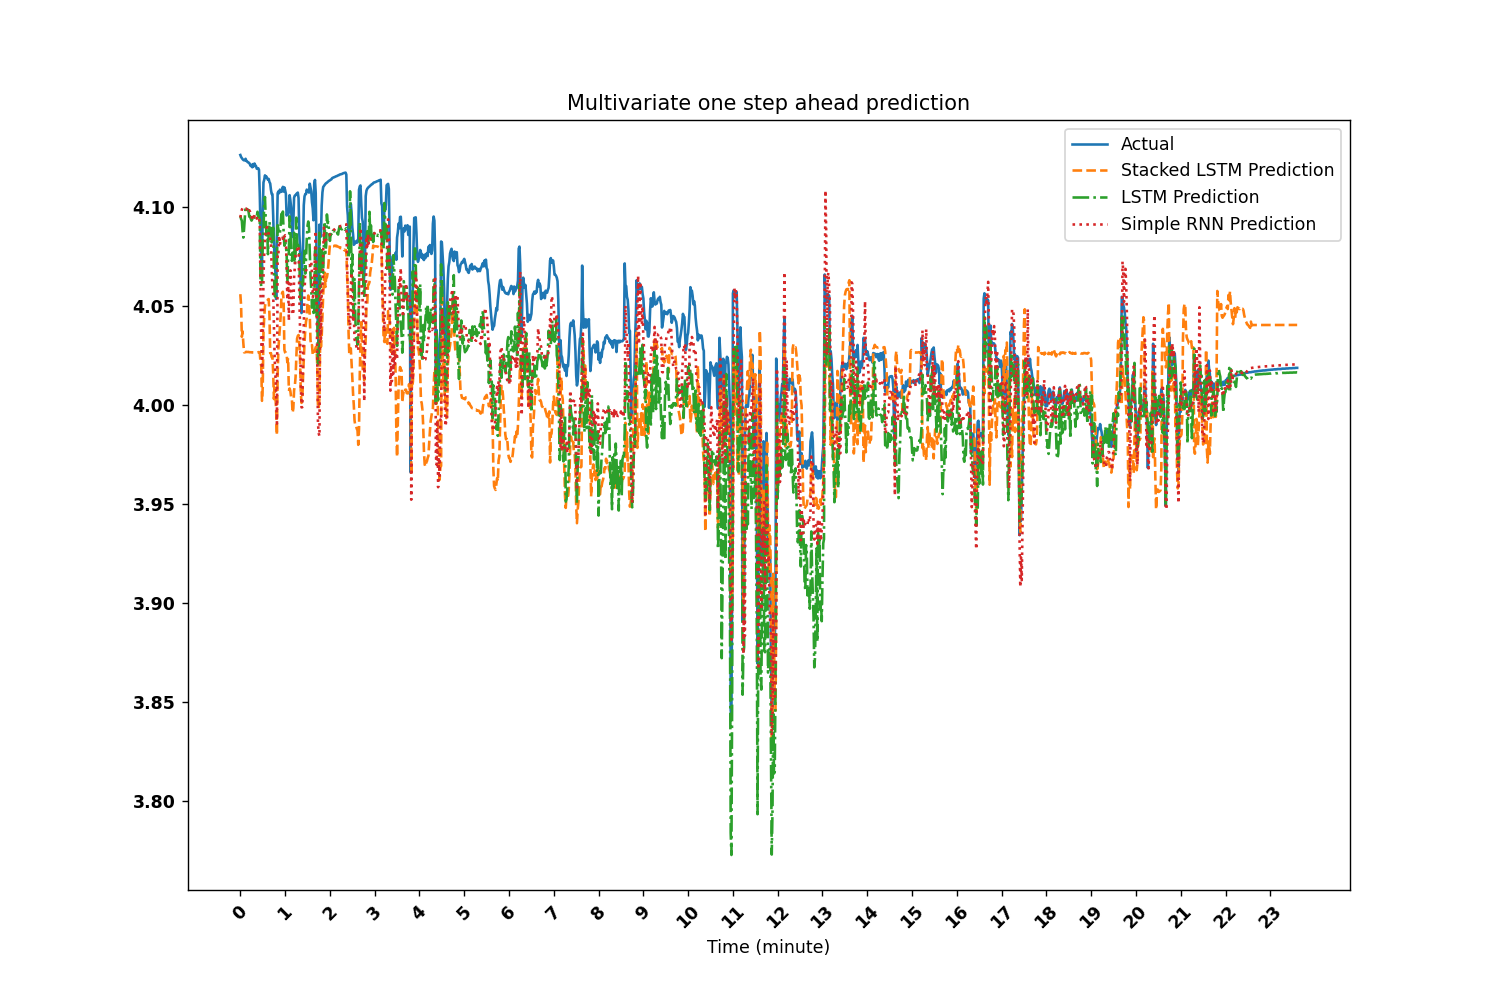

In [142]:
# Combined plot
save_path = os.path.join(cwd, 'figures', 'final', "combined_one_worse" + '.pdf')
plot_multi_line(("Multivariate one step ahead prediction", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (stacked_predictions, "Stacked LSTM Prediction"), (lstm_predictions, "LSTM Prediction"), (rnn_predictions, "Simple RNN Prediction"))

## Make box plot

In [143]:
# load cycle
df_test = li_train_cycles[6].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test.iloc[1000:1700]    # for clear visibility, take only last few steps

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

In [144]:
# load RNN models
from keras.models import load_model

path_0 = os.path.join(cwd, 'generalized', 'RNN', 'model' + str(0) + '.h5')
path_1 = os.path.join(cwd, 'generalized', 'RNN', 'model' + str(1) + '.h5')
path_2 = os.path.join(cwd, 'generalized', 'RNN', 'model' + str(2) + '.h5')
path_3 = os.path.join(cwd, 'generalized', 'RNN', 'model' + str(3) + '.h5')
path_4 = os.path.join(cwd, 'generalized', 'RNN', 'model' + str(4) + '.h5')

rnn_0 = load_model(path_0)
rnn_1 = load_model(path_1)
rnn_2 = load_model(path_2)
rnn_3 = load_model(path_3)
rnn_4 = load_model(path_4)


rnn_pred0 = rnn_0.predict(X)
rnn_pred0 = np.squeeze(rnn_pred0)

rnn_pred1 = rnn_1.predict(X)
rnn_pred1 = np.squeeze(rnn_pred1)

rnn_pred2 = rnn_2.predict(X)
rnn_pred2 = np.squeeze(rnn_pred2)

rnn_pred3 = rnn_3.predict(X)
rnn_pred3 = np.squeeze(rnn_pred3)

rnn_pred4 = rnn_4.predict(X)
rnn_pred4 = np.squeeze(rnn_pred4)

li_rnn_errors = [mse(y, rnn_pred0, squared=False), mse(y, rnn_pred1, squared=False), mse(y, rnn_pred2, squared=False), 
                 mse(y, rnn_pred3, squared=False), mse(y, rnn_pred4, squared=False)]


In [183]:
# load LSTM models

path_0 = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(0) + '.h5')
path_1 = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(1) + '.h5')
path_2 = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(2) + '.h5')
# path_3 = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str('more_epochs') + '.h5')

lstm_0 = load_model(path_0)
lstm_1 = load_model(path_1)
lstm_2 = load_model(path_2)
# lstm_3 = load_model(path_3)


lstm_pred0 = lstm_0.predict(X)
lstm_pred0 = np.squeeze(lstm_pred0)

lstm_pred1 = lstm_1.predict(X)
lstm_pred1 = np.squeeze(lstm_pred1)

lstm_pred2 = lstm_2.predict(X)
lstm_pred2 = np.squeeze(lstm_pred2)

li_lstm_errors = [mse(y, lstm_pred0, squared=False), mse(y, lstm_pred1, squared=False), mse(y, lstm_pred2, squared=False)]


In [187]:
# li_lstm_errors.append(0.01758778767318353)
# li_lstm_errors.append(0.021)
# print(li_lstm_errors)

In [188]:
# load stackd stacked models

path_0 = os.path.join(cwd, 'generalized', 'stacked_LSTM', 'model' + str(0) + '.h5')
path_1 = os.path.join(cwd, 'generalized', 'stacked_LSTM', 'model' + str(1) + '.h5')
path_2 = os.path.join(cwd, 'generalized', 'stacked_LSTM', 'model' + str(2) + '.h5')
path_3 = os.path.join(cwd, 'generalized', 'stacked_LSTM', 'model' + str(3) + '.h5')
path_4 = os.path.join(cwd, 'generalized', 'stacked_LSTM', 'model' + str(4) + '.h5')

stacked_0 = load_model(path_0)
stacked_1 = load_model(path_1)
stacked_2 = load_model(path_2)
stacked_3 = load_model(path_3)
stacked_4 = load_model(path_4)

stacked_pred0 = stacked_0.predict(X)
stacked_pred0 = np.squeeze(stacked_pred0)

stacked_pred1 = stacked_1.predict(X)
stacked_pred1 = np.squeeze(stacked_pred1)

stacked_pred2 = stacked_2.predict(X)
stacked_pred2 = np.squeeze(stacked_pred2)

stacked_pred3 = stacked_3.predict(X)
stacked_pred3 = np.squeeze(stacked_pred3)

stacked_pred4 = stacked_4.predict(X)
stacked_pred4 = np.squeeze(stacked_pred4)

li_stacked_errors = [mse(y, stacked_pred0, squared=False), mse(y, stacked_pred1, squared=False), mse(y, stacked_pred2, squared=False),
                    mse(y, stacked_pred3, squared=False), mse(y, stacked_pred4, squared=False)]

print(li_stacked_errors)

[0.04791634904542554, 0.04791634904542554, 0.04791634904542554, 0.04791634904542554, 0.04791634904542554]


In [232]:
# All error lists in one dataframe
df_rmse = pd.DataFrame(
    {'RNN': li_rnn_errors,
     'LSTM': li_lstm_errors,
     'Stacked_LSTM': li_stacked_errors
    })

# rnn_data = df.describe()
print(df_rmse)
# print(df_rmse.describe())
# df_rmse = df_rmse.describe()
print(df_rmse.describe())
print(type(df_rmse))

        RNN      LSTM  Stacked_LSTM
0  0.011929  0.012547      0.047916
1  0.011142  0.012547      0.047916
2  0.034561  0.019588      0.047916
3  0.011929  0.017588      0.047916
4  0.011929  0.021000      0.047916
            RNN      LSTM  Stacked_LSTM
count  5.000000  5.000000      5.000000
mean   0.016298  0.016654      0.047916
std    0.010215  0.003940      0.000000
min    0.011142  0.012547      0.047916
25%    0.011929  0.012547      0.047916
50%    0.011929  0.017588      0.047916
75%    0.011929  0.019588      0.047916
max    0.034561  0.021000      0.047916
<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>


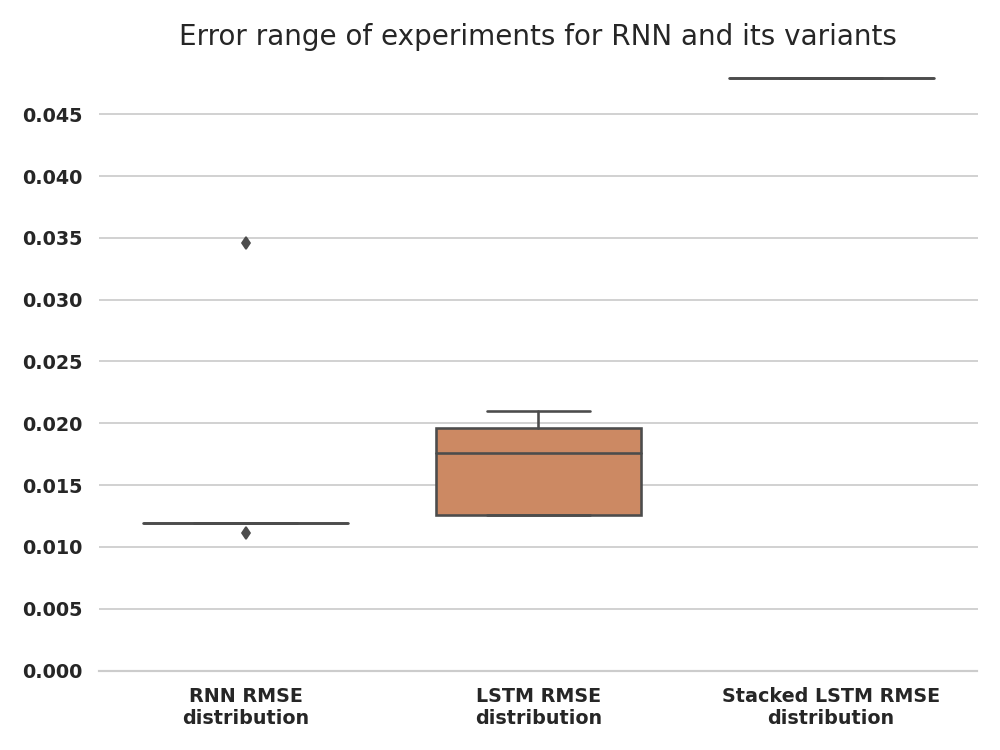

g.artists:  0
g:  AxesSubplot(0.125,0.11;0.775x0.77)


In [231]:
%matplotlib notebook

save_path = os.path.join(cwd, 'figures', 'final', "box_ploy" + '.pdf')

# Import libraries
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
# g = sns.boxplot(data=df_rmse[['RNN','LSTM','Stacked_LSTM']], width=0.7)
g = sns.boxplot(data=df_rmse, width=0.7)

# Titles and labels
plt.title("Error range of experiments for RNN and its variants", fontsize=16)

xvalues = ["RNN RMSE\ndistribution","LSTM RMSE\ndistribution","Stacked LSTM RMSE\ndistribution"] 

# set xvalues as xtick values
plt.xticks(np.arange(3), xvalues)

# set y-axis values (I only want whole numbers)
plt.yticks(np.arange(0, 0.05, step=0.005))


# remove all borders except bottom
sns.despine(top=True,
            right=True,
            left=True,
            bottom=False)

print("g.artists: ", len(g.artists))
print("g: ", g)

# Set colors of box plots 
# https://cmdlinetips.com/2018/11/how-to-assign-specific-colors-to-boxplots-in-seaborn/
# palette= ['g','orange','r']
# color_dict = dict(zip(xvalues, palette))
# for i in range(0,3):
#     mybox = g.artists[i]
#     mybox.set_facecolor(color_dict[xvalues[i]])


# ### Provide mean and standard deviation for each product ###   
# # Text RNN
# mean = 0.0162 #round(df_rmse['RNN'].mean(),1)
# sd = 0.0102 #round(df_rmse['RNN'].std(),1)
# textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
# props = dict(boxstyle='round', facecolor='plum', alpha=0.2)
# g.text(-0.19, 1.1, textstr, fontsize=12, bbox=props)

# # Text LSTM
# mean = 0.0167 #round(df_rmse['LSTM'].mean(),1)
# sd = 0.0039 #round(df_rmse['LSTM'].std(),1)
# textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
# props = dict(boxstyle='round', facecolor='g', alpha=0.2)
# g.text(.81, 1.1, textstr, fontsize=12, bbox=props)

# # Text p3
# mean = 0.0479 #round(df_rmse['Stacked_LSTM'].mean(),1)
# sd = 0 #round(df_rmse['Stacked_LSTM'].std(),1)
# textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
# props = dict(boxstyle='round', facecolor='orange', alpha=0.2)
# g.text(1.81, 1.1, textstr, fontsize=12, bbox=props)


# data = [li_rnn_data]
# # print(li_rnn_errors.describe())
# fig = plt.figure(figsize =(10, 5))

# Creating axes instance
# [x0, y0, width, height] denoting the lower left point of the new axes in figure coodinates (x0,y0) and its width and height.
# So the axes is positionned in absolute coordinates on the canvas.
# ax = fig.add_axes([0, 0, 1, 1])  # places a figure in the canvas that is exactly as large as the canvas itself.

 
# Creating plot
# bp = ax.boxplot(data)
# sns.boxplot(df_rmse["RNN"], orient='v')
plt.tight_layout()
plt.show()

plt.savefig(save_path)

## Rolling forecast for small window

In [14]:
# load cycle
df_test = li_train_cycles[6].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test.iloc[1000:1100]    # for clear visibility, take only last few steps

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y
print(X.shape, y.shape)

(90, 10, 3) (90,)


In [15]:
# for each window, forecast next 10 points and also compute RMSE for each window

rolling_window_len = 10 # OCV
TIMESTEPS = 10
forecast_secs = 10

X1 = X[:10].copy()
X2 = X[10:20].copy()
X3 = X[20:30].copy()
X4 = X[30:40].copy()
X5 = X[40:50].copy()
X6 = X[50:60].copy()
X7 = X[60:70].copy()
X8 = X[70:80].copy()
X9 = X[80:90].copy()

y1 = y[:10].copy()
y2 = y[10:20].copy()
y3 = y[20:30].copy()
y4 = y[30:40].copy()
y5 = y[40:50].copy()
y6 = y[50:60].copy()
y7 = y[60:70].copy()
y8 = y[70:80].copy()
y9 = y[80:90].copy()

# # lstm model
model_path = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(1) + '.h5')

# forecast list
y1_pred = get_forecast_list(model_path, X1, forecast_secs, TIMESTEPS)   # first window output
y1_rmse = list()
for i, val in enumerate(y1):
#     print(i, val)
    y_each = y1[:i+1]
    y_pred_each = y1_pred[:i+1]
#     print(y_each)
#     print(y_pred_each)
    y1_rmse.append(mse(y_each, y_pred_each, squared=False))    

y2_pred = get_forecast_list(model_path, X2, forecast_secs, TIMESTEPS)   # first window output
y2_rmse = list()
for i, val in enumerate(y2):
    y_each = y2[:i+1]
    y_pred_each = y2_pred[:i+1]
    y2_rmse.append(mse(y_each, y_pred_each, squared=False))

y3_pred = get_forecast_list(model_path, X3, forecast_secs, TIMESTEPS)   # first window output
y3_rmse = list()
for i, val in enumerate(y3):
    y_each = y3[:i+1]
    y_pred_each = y3_pred[:i+1]
    y3_rmse.append(mse(y_each, y_pred_each, squared=False))

y4_pred = get_forecast_list(model_path, X4, forecast_secs, TIMESTEPS)   # first window output
y4_rmse = list()
for i, val in enumerate(y4):
    y_each = y4[:i+1]
    y_pred_each = y4_pred[:i+1]
    y4_rmse.append(mse(y_each, y_pred_each, squared=False))

y5_pred = get_forecast_list(model_path, X5, forecast_secs, TIMESTEPS)   # first window output
y5_rmse = list()
for i, val in enumerate(y5):
    y_each = y5[:i+1]
    y_pred_each = y5_pred[:i+1]
    y5_rmse.append(mse(y_each, y_pred_each, squared=False))

y6_pred = get_forecast_list(model_path, X6, forecast_secs, TIMESTEPS)   # first window output
y6_rmse = list()
for i, val in enumerate(y6):
    y_each = y6[:i+1]
    y_pred_each = y6_pred[:i+1]
    y6_rmse.append(mse(y_each, y_pred_each, squared=False))

y7_pred = get_forecast_list(model_path, X7, forecast_secs, TIMESTEPS)   # first window output
y7_rmse = list()
for i, val in enumerate(y7):
    y_each = y7[:i+1]
    y_pred_each = y7_pred[:i+1]
    y7_rmse.append(mse(y_each, y_pred_each, squared=False))

y8_pred = get_forecast_list(model_path, X8, forecast_secs, TIMESTEPS)   # first window output
y8_rmse = list()
for i, val in enumerate(y8):
    y_each = y8[:i+1]
    y_pred_each = y8_pred[:i+1]
    y8_rmse.append(mse(y_each, y_pred_each, squared=False))

y9_pred = get_forecast_list(model_path, X9, forecast_secs, TIMESTEPS)   # first window output
y9_rmse = list()
for i, val in enumerate(y9):
    y_each = y9[:i+1]
    y_pred_each = y9_pred[:i+1]
    y9_rmse.append(mse(y_each, y_pred_each, squared=False))

# print(y1_pred, y1_rmse)

# concat forecast of all windows
li_pred = y1_pred + y2_pred + y3_pred + y4_pred + y5_pred + y6_pred + y7_pred + y8_pred + y9_pred
li_rmse = y1_rmse + y2_rmse + y3_rmse + y4_rmse + y5_rmse + y6_rmse + y7_rmse + y8_rmse + y9_rmse

# fill the first 10 values with NAN
li_empty = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
li_pred = li_empty + li_pred
li_rmse = li_empty + li_rmse

# fill the first 10 elements of y
y_first = df_test["V"][0:10].copy()
y_first = np.array(y_first)
y = np.concatenate((y_first, y))

li_forecast = np.array(li_pred)
forecast_rmse = np.array(li_rmse)

print(len(li_forecast), len(forecast_rmse))

x_axis = np.arange(y.shape[0])


2022-08-29 19:33:43.022693: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-29 19:33:43.022741: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: avt-System-Product-Name
2022-08-29 19:33:43.022750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: avt-System-Product-Name
2022-08-29 19:33:43.022833: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.82.1
2022-08-29 19:33:43.022857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.1
2022-08-29 19:33:43.022865: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.82.1


100 100


In [24]:
def multi_scale_plot_seconds(*axes):

    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

    plt.rc('font', **font)

    # More versatile wrapper
    fig, host = plt.subplots(figsize=(10,7)) # (width, height) in inches
    # (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

    # assign argument values
    title, save_path = axes[0]
    x_data, x_label = axes[1]
    y1_data, y1_label = axes[2]
    y2_data, y2_label = axes[3]
    y3_data, y3_label = axes[4]

    par1 = host.twinx()
    par2 = host.twinx()

    scale_x = 1     # show seconds, no scaling
    li_ticks = np.arange(min(x_data), max(x_data)+1, 10)     # every 60 seconds = 1 minutes freq, assuming 1 Hz sampling rate
    li_labels = list(map(lambda x: int(x/scale_x), li_ticks))      # 60 sec = 1 minutes
    par2.xaxis.set_ticks(li_ticks, li_labels, rotation=45)
    host.set_xlabel('Time (seconds)')

    # Set y axis labels
    host.set_ylabel(y1_label)
    par1.set_ylabel(y2_label)
    par2.set_ylabel(y3_label)

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

    # These labels are in the box
    p1, = host.plot(x_data, y1_data,    color=color1, label=y1_label)
    p2, = par1.plot(x_data, y2_data,    color=color2, label=y2_label)
    p3, = par2.plot(x_data, y3_data, color=color3, label=y3_label)

    lns = [p1, p2, p3]
#     host.legend(handles=lns, loc='lower center')
    host.legend(handles=lns, loc='upper right')

    # right, left, top, bottom
    # par2.spines['right'].set_position(('outward', 60))

    # no x-ticks                 
    # par2.xaxis.set_ticks([])

    # set ticks y axis
    if "Contactor" in y3_label:
        par2.yaxis.set_ticks([0,2,2])        # manually set as contactor state can be either 0 or 2

    # Move "y3 -axis to the left
    par2.spines['left'].set_position(('outward', 60))
    par2.spines['left'].set_visible(True)
    par2.yaxis.set_label_position('left')
    par2.yaxis.set_ticks_position('left')

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    # Best for professional typesetting, e.g. LaTeX
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    # For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'

In [30]:
import statistics
rmse = li_rmse[10:]
print(statistics.mean(rmse))

print(max(rmse))

0.014165226971319434
0.034278532011162086


<IPython.core.display.Javascript object>


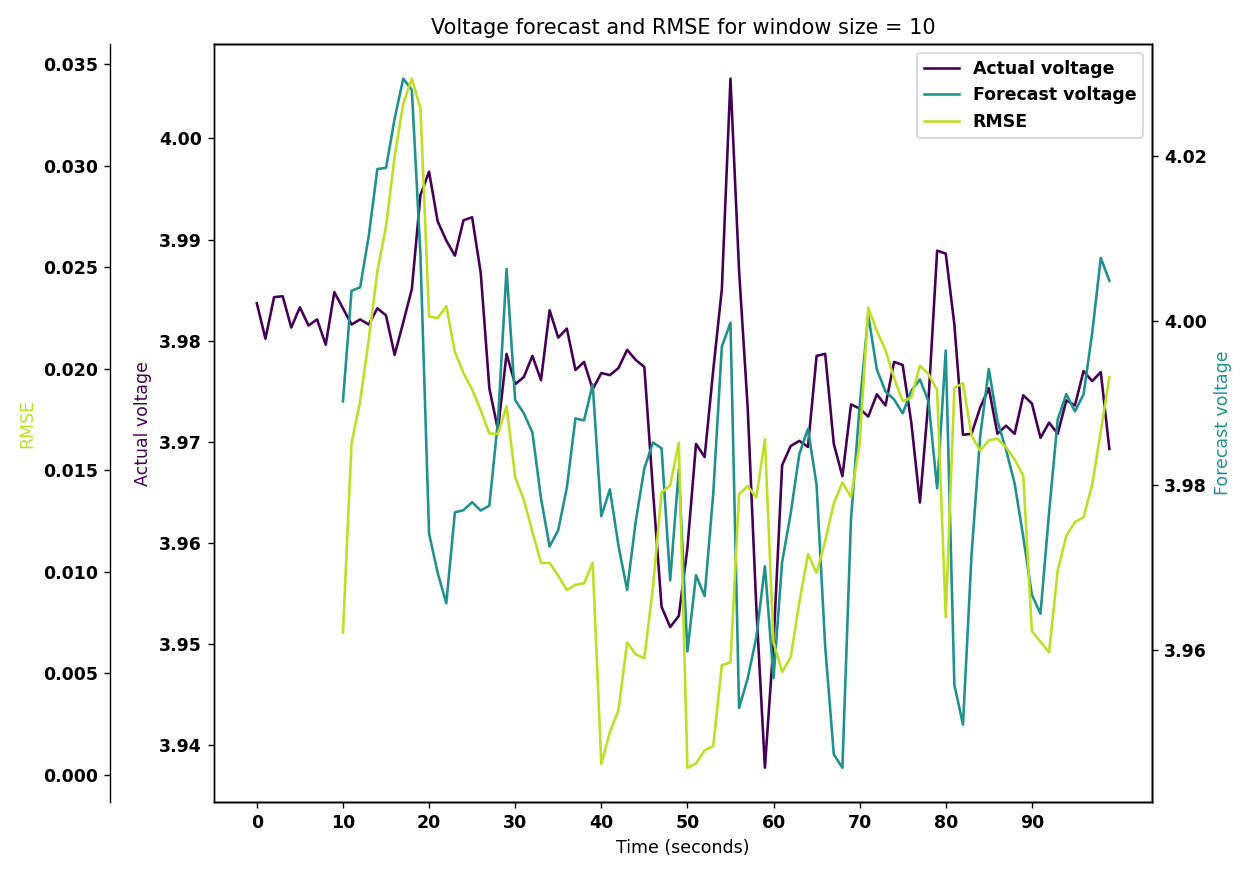

In [26]:
%matplotlib notebook

save_path = os.path.join(cwd, 'figures', 'final', "forecast_window_10" + '.png')
multi_scale_plot_seconds(("Voltage forecast and RMSE for window size = 10", save_path), (x_axis, constants.x_label_elapsedtime), (y, "Actual voltage"), (li_forecast, "Forecast voltage"), (forecast_rmse, "RMSE"))

## OCV forecast

In [32]:
# load cycle
df_test = li_train_cycles[6].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test.iloc[1000:1100]    # for clear visibility, take only last few steps
df_test['current'].iloc[30:] = 0     # set current=0 after timesteps

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y
print(X.shape, y.shape)

(90, 10, 3) (90,)


In [41]:
import matplotlib
def plot_multi_line_sec(*axes):

    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

    matplotlib.rc('font', **font)
    fig = plt.figure(figsize =(12 ,8))

    # Set line style for different lines, 5 lines max
    li_linestyle = ["-", "--", "-.", ":"]

    # assign argument values
    title, save_path, y_axis_label = axes[0]
    x_data, x_label = axes[1]
    
    # Gather all y axis labels and data
    for i in range(2, len(axes)):
        y_data, y_label = axes[i]
        # print(y_data, y_label)
        plt.plot(x_data, y_data, label = y_label, linestyle=li_linestyle[i-2])

    # X label and Y label
    scale_x = 1
    li_ticks = np.arange(min(x_data), max(x_data)+1, 10)     # every 60 seconds = 1 minutes freq
    li_labels = list(map(lambda x: int(x/scale_x), li_ticks))      # 60 sec = 1 minutes
    plt.xticks(li_ticks, li_labels, rotation=45)
    plt.xlabel('Time (minute)')


    plt.title(title) # set the whole plot name
    plt.legend(bbox_to_anchor=(1.0, 1.0),prop={'size': 10,'weight' :'normal'})
    plt.show()
    fig.savefig(save_path)

<IPython.core.display.Javascript object>


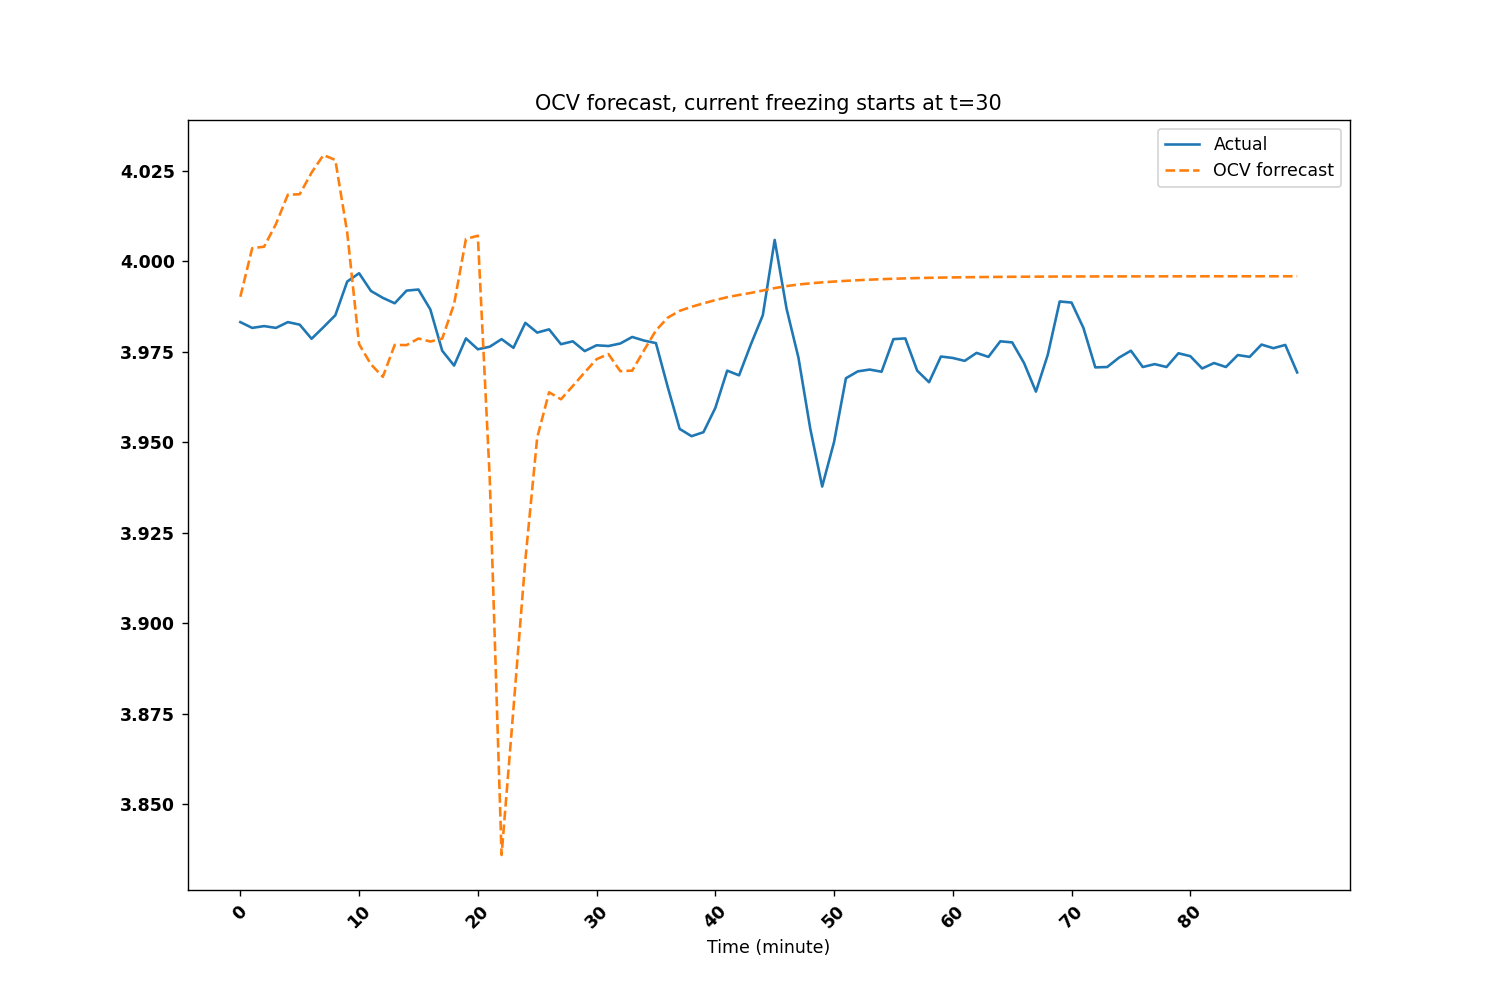

In [43]:
ocv_pred = get_forecast_list(model_path, X, 100, TIMESTEPS)   # first window output
ocv_pred = np.array(ocv_pred)
x_axis = np.arange(y.shape[0])

save_path = os.path.join(cwd, 'figures', 'final', "ocv_forecast" + '.pdf')
plot_multi_line_sec(("OCV forecast, current freezing starts at t=30", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (ocv_pred, "OCV forrecast"))

In [121]:
print(mape(y, rnn_predictions))
print(mse(y, rnn_predictions, squared=False))

print(mape(y, lstm_predictions))
print(mse(y, lstm_predictions, squared=False))

print(mape(y, stacked_predictions))
print(mse(y, stacked_predictions, squared=False))

0.0024753378796047074
0.011928670876721002
0.0024215629941421557
0.012547265180751256
0.011016597014525138
0.04791634904542554


[4.034122 4.034244 4.027886 ... 3.96396  3.96396  3.96396 ]


<IPython.core.display.Javascript object>


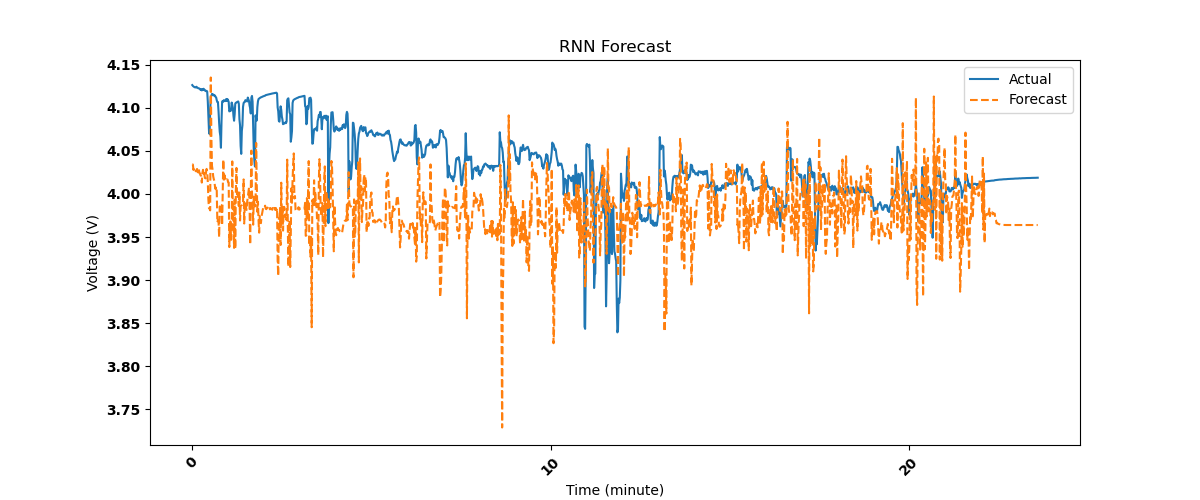

In [264]:

%matplotlib notebook

# FOrecast
iteration_no = 2
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'RNN', 'model' + str(iteration_no) + '.h5')

# forecast list
li_test_forecast = get_forecast_list(model_path, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
rnn_forecast = np_test_forecast

rnn_forecast = np_test_forecast
x_axis = np.arange(rnn_forecast.shape[0])
print(rnn_forecast)

y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'generalized', 'RNN', 'model_less_data_points' + str(iteration_no) + 'pdf')
custom_plot.plot_multi_line(("RNN Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (rnn_forecast, "Forecast"))

### Generalized LSTM prediction

### concat many cycles

In [20]:

df_test1 = li_train_cycles[2].copy()
df_test1 = df_test1[['V', 'current', 'Temp']]   # only necessary columns

df_test2 = li_train_cycles[3].copy()
df_test2 = df_test2[['V', 'current', 'Temp']]   # only necessary columns

df_test3 = li_train_cycles[4].copy()
df_test3 = df_test3[['V', 'current', 'Temp']]   # only necessary columns

df_test4 = li_train_cycles[5].copy()
df_test4 = df_test4[['V', 'current', 'Temp']]   # only necessary columns

df_test5 = li_train_cycles[6].copy()
df_test5 = df_test5[['V', 'current', 'Temp']]   # only necessary columns

df_test6 = li_train_cycles[7].copy()
df_test6 = df_test6[['V', 'current', 'Temp']]   # only necessary columns

df_test7 = li_test_cycles[0].copy()
df_test7 = df_test7[['V', 'current', 'Temp']]   # only necessary columns

df_test8 = li_test_cycles[1].copy()
df_test8 = df_test8[['V', 'current', 'Temp']]   # only necessary columns

frames = [df_test1, df_test2, df_test3, df_test4, df_test5 , df_test6, df_test7, df_test8]
df_test_concat = pd.concat(frames)
X, y = df_to_supervised_multivariate(df_test_concat.to_numpy(), TIMESTEPS, 0)  # preprocess for concat same test data one after another for 10 times
print(X.shape, y.shape)

(20392, 10, 3) (20392,)


In [15]:
# df_test = li_train_cycles[2].copy()
# # df_test = li_test_cycles[1].copy()
# TIMESTEPS = 10
# # print(len(df_test))
# iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
# df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# # print(len(df_test))

# df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
# # df_reverse = df_test.iloc[::-1] # reverse
# frames = [df_test, df_test]
# df_test_concat = pd.concat(frames)

# # X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y
# # X, y = df_to_supervised_multivariate(df_reverse.to_numpy(), TIMESTEPS, 0)  # preprocess for reverse test data
# X, y = df_to_supervised_multivariate(df_test_concat.to_numpy(), TIMESTEPS, 0)  # preprocess for concat same test data one after another for 10 times
# print(X.shape, y.shape)

(2844, 10, 3) (2844,)


In [21]:
# 1 step prediction
iteration_no = 1
# FORECAST_SECONDS = len(df_test)
FORECAST_SECONDS = y.shape[0]

model_path = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(iteration_no) + '.h5')
from keras.models import load_model
model = load_model(model_path)
print(X.shape, y.shape)
lstm_gen_predictions = model.predict(X)
lstm_gen_predictions = np.squeeze(lstm_gen_predictions)
print(lstm_gen_predictions.shape)


(20392, 10, 3) (20392,)
(20392,)


<IPython.core.display.Javascript object>


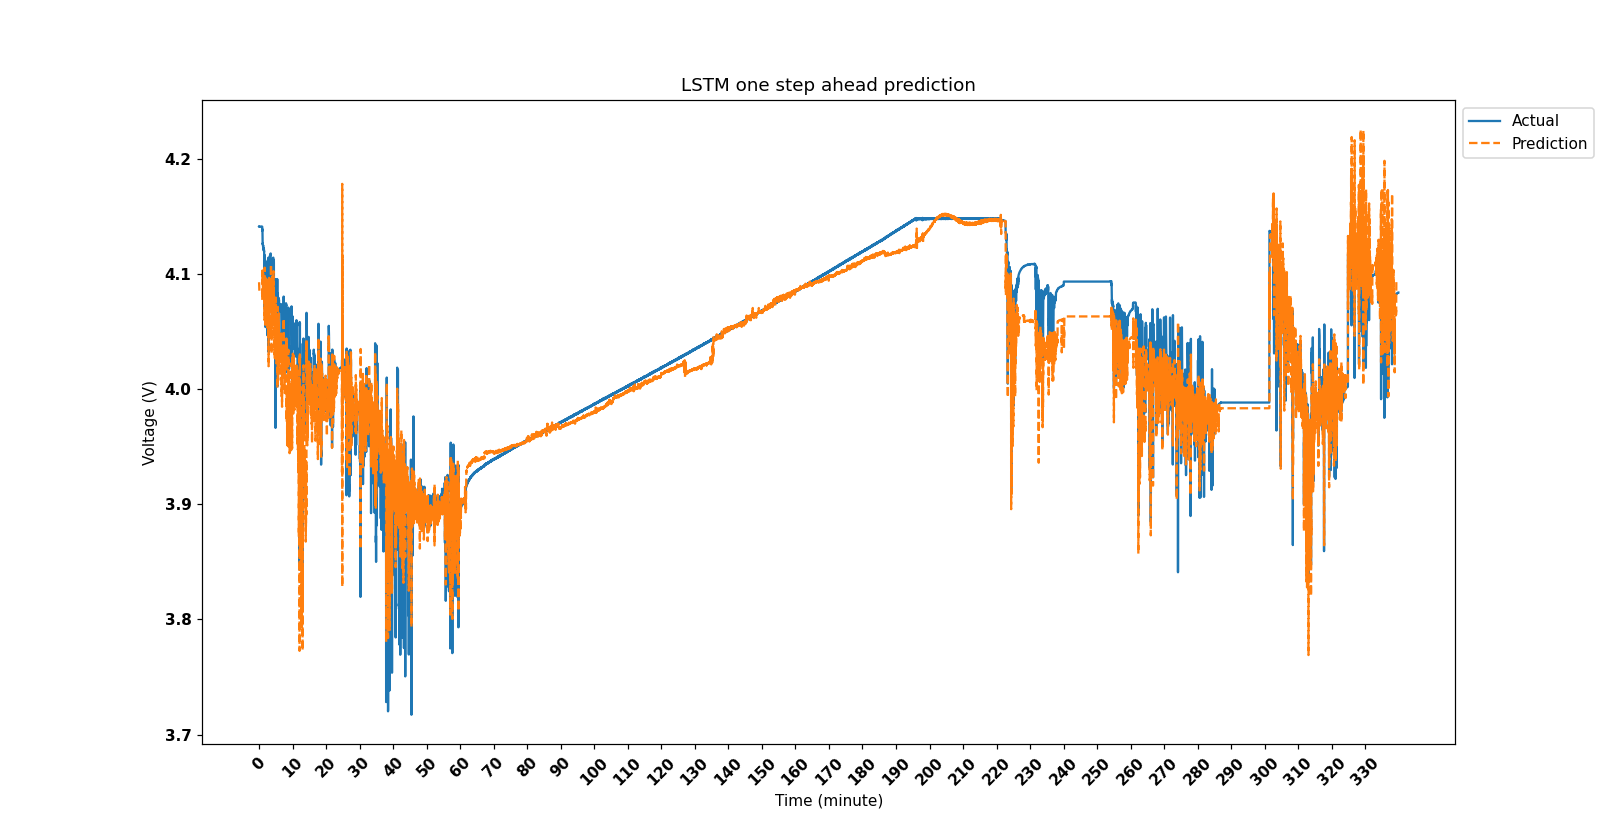

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [22]:
%matplotlib notebook

x_axis = np.arange(lstm_gen_predictions.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'generalized', 'LSTM', 'model_predict_test_concat_train_test' + str(iteration_no) + '.pdf')
custom_plot.plot_multi_line(("LSTM one step ahead prediction", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (lstm_gen_predictions, "Prediction"))

In [207]:
print(lstm_gen_predictions)

[4.0956793 4.094139  4.0933275 ... 4.0165625 4.016638  4.016611 ]


In [266]:
# Forecast with LSTM
iteration_no = 1
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(iteration_no) + '.h5')

# forecast list
li_test_forecast = get_forecast_list(model_path, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
lstm_forecast = np_test_forecast

<IPython.core.display.Javascript object>


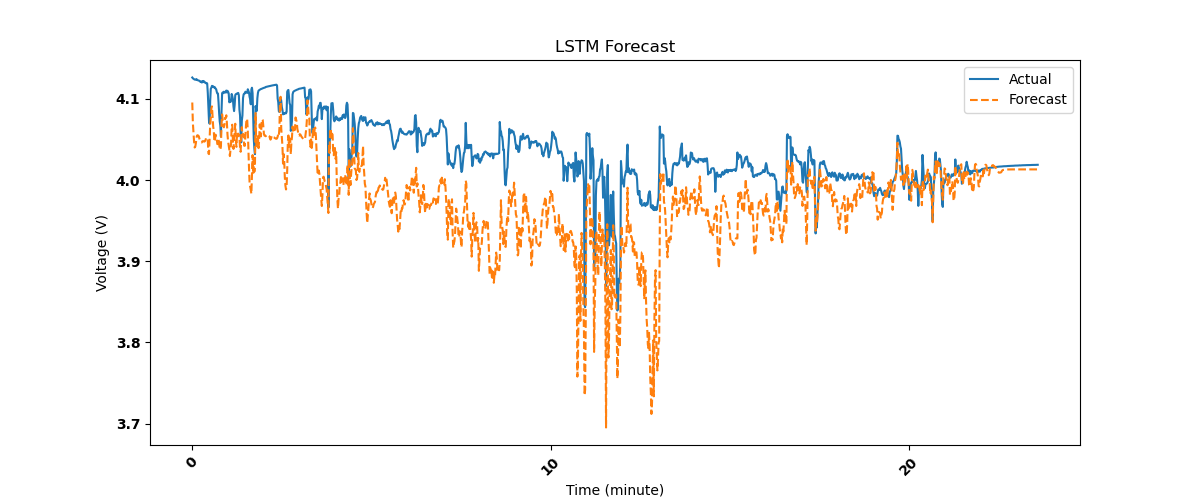

In [267]:
%matplotlib notebook
x_axis = np.arange(lstm_forecast.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(iteration_no) + 'pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (lstm_forecast, "Forecast"))

### Cross validation LSTM model with incremental horizontal

In [224]:
# These models use 5 timesteps as lookback 
TIMESTEPS = 5

df_test = li_train_cycles[2].copy()
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y


# iteration_no = 1
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'inc_models_result', 'vanila_lstm', '7_2',  'model' + '.h5')

# forecast list
li_test_forecast = get_forecast_list(model_path, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
lstm_inc_forecast = np_test_forecast

<IPython.core.display.Javascript object>


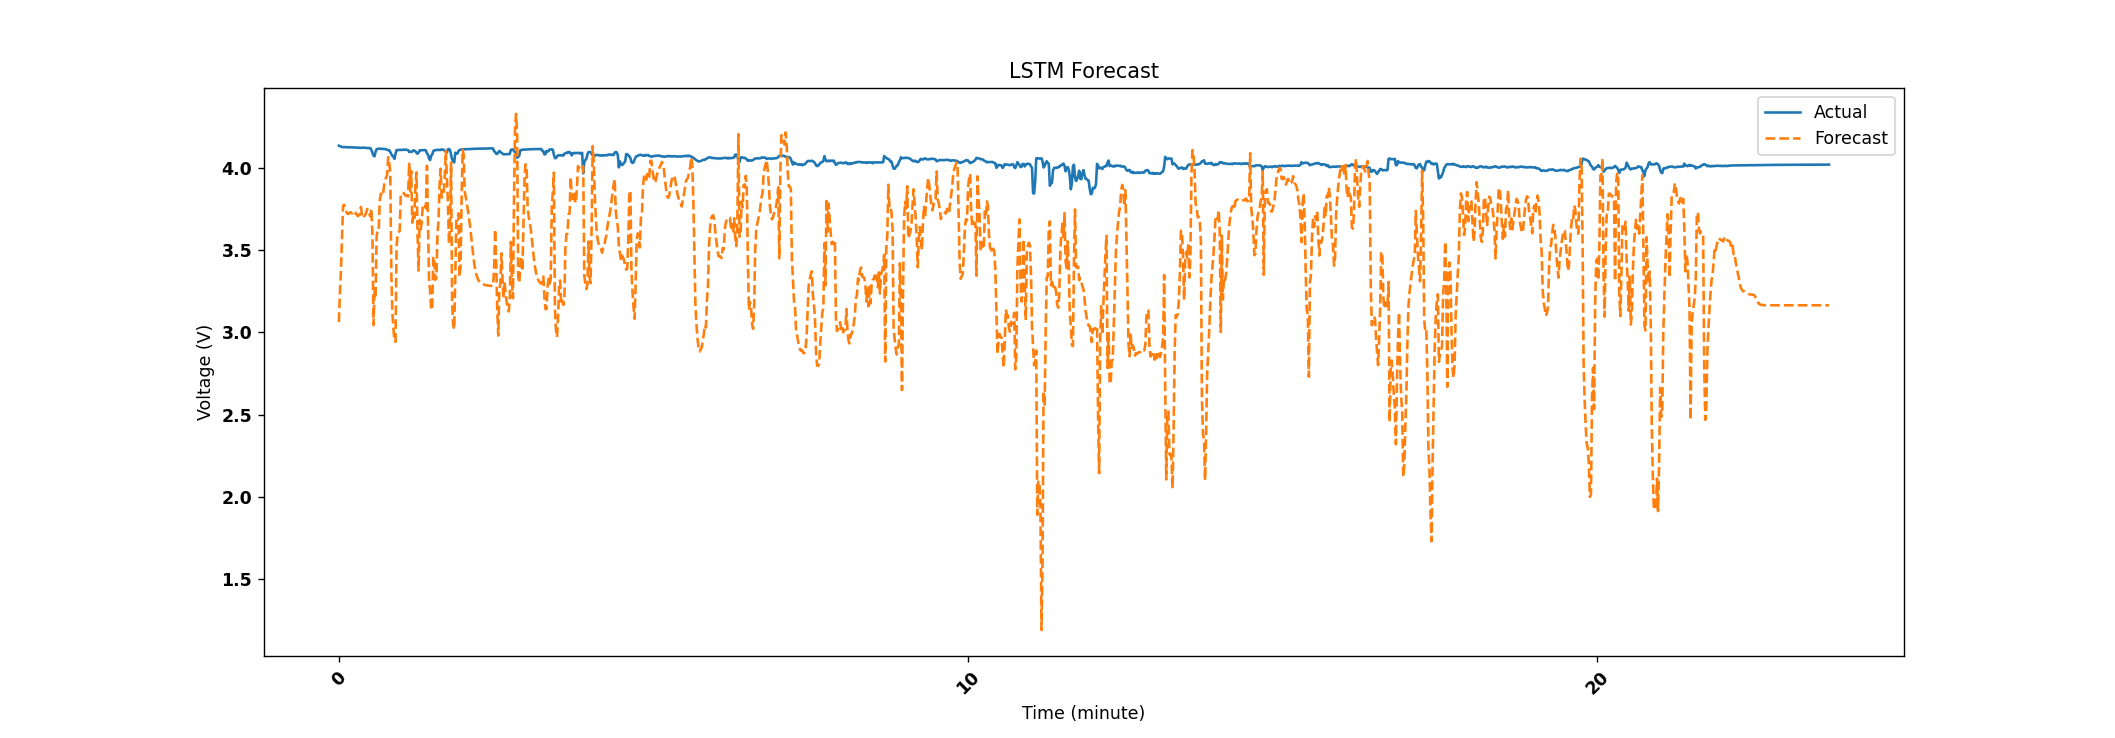

In [225]:
%matplotlib notebook
x_axis = np.arange(lstm_inc_forecast.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'inc_models_result', 'vanila_lstm', '7_2' + '.pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (lstm_inc_forecast, "Forecast"))

### Generalized Stacked LSTM forecast

In [229]:
# Predict with LSTM
iteration_no = 0
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'stacked_LSTM', 'model' + str(iteration_no) + '.h5')

# forecast list
li_test_forecast = get_forecast_list(model_path, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
stacked_lstm_forecast = np_test_forecast

<IPython.core.display.Javascript object>


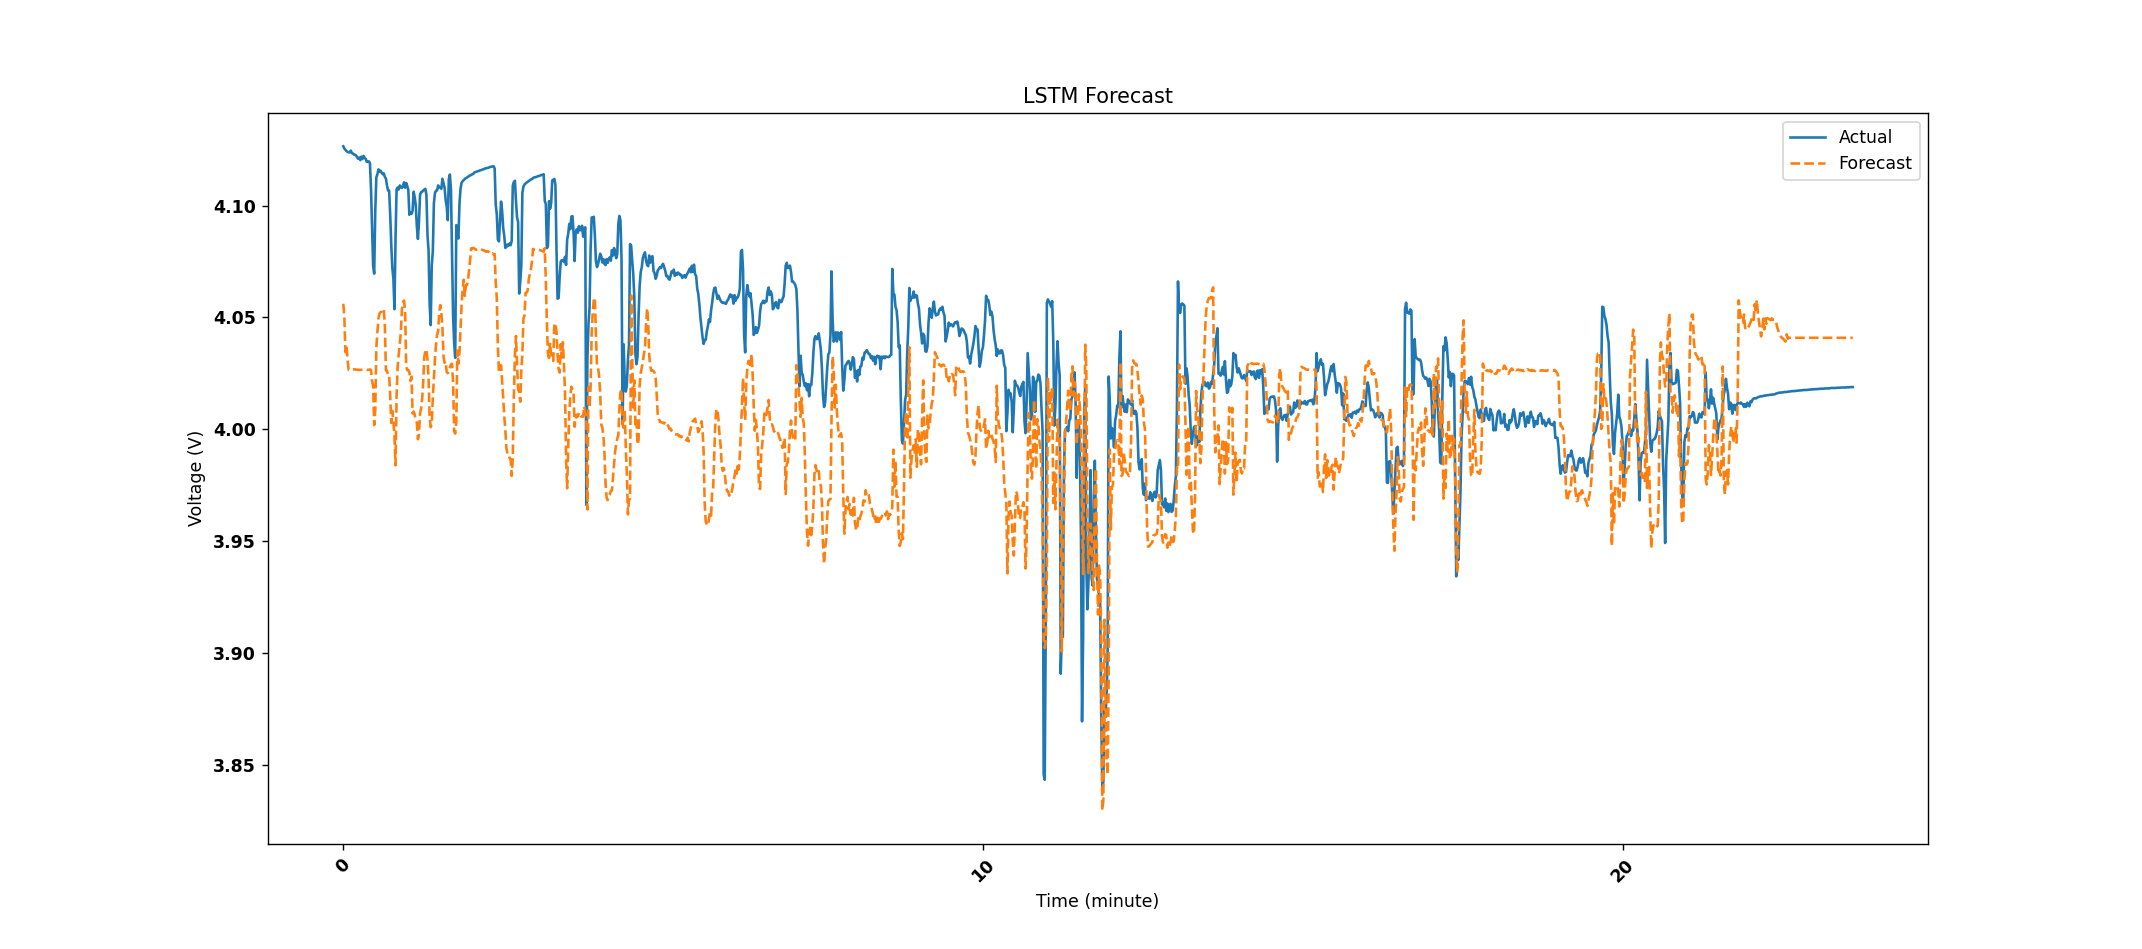

In [230]:
%matplotlib notebook
x_axis = np.arange(stacked_lstm_forecast.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'generalized', 'stacked_LSTM', 'model' + str(iteration_no) + 'pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (stacked_lstm_forecast, "Forecast"))

### LSTM scaled

In [215]:
df_test = li_train_cycles[2].copy()
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns

X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

# standard transformation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_test)    # just fit, not transform yet
df_test_scaled = scaler.transform(df_test)
# print(df_test_scaled)
print('\nmean after standard scaling', df_test_scaled.mean(axis=0))     # mean, almost zero
print('standard deviation after standard scaling', df_test_scaled.std(axis=0))    # variance

X_scaled, y_scaled = df_to_supervised_multivariate(df_test_scaled, TIMESTEPS, 0)  # scaled X and y


mean after standard scaling [ 6.41330794e-15 -1.99171054e-17  1.99171054e-16]
standard deviation after standard scaling [1. 1. 1.]


In [ ]:
# 1 step prediction
iteration_no = 1
FORECAST_SECONDS = len(df_test)

model_path = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(iteration_no) + '.h5')
from keras.models import load_model
model = load_model(model_path)
print(X.shape)
lstm_gen_predictions = model.predict(X)
lstm_gen_predictions = np.squeeze(lstm_gen_predictions)
print(lstm_gen_predictions.shape)

In [315]:
# Predict with LSTM
iteration_no = 0
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'model_LSTM_mutivariate')

# forecast list
# This models uses standard scaled transformation training, so feed scaled input
li_test_forecast = get_forecast_list(model_path, X_scaled, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
lstm_multivar = np_test_forecast

ValueError: in user code:

    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 10, 3), found shape=(None, 20, 3)


In [209]:
expand = np.expand_dims(lstm_multivar, axis=1)
# print(expand.shape)
# print(expand)
lstm_multivar_copies = np.repeat(expand, X.shape[2], axis=1)   # expand so that inverse transform can happen
# print(lstm_multivar_copies)
li_lstm_multivar_forecast = scaler.inverse_transform(lstm_multivar_copies)


In [210]:
# print(li_lstm_multivar_forecast)
indices = [0]      # only voltage, voltage is the 0th index
y_pred = np.take(li_lstm_multivar_forecast, indices, axis = 1)
y_pred = y_pred.flatten()
print(y_pred)

[4.086807  4.0857143 4.0843234 ... 4.0217166 4.0216603 4.0216055]


<IPython.core.display.Javascript object>


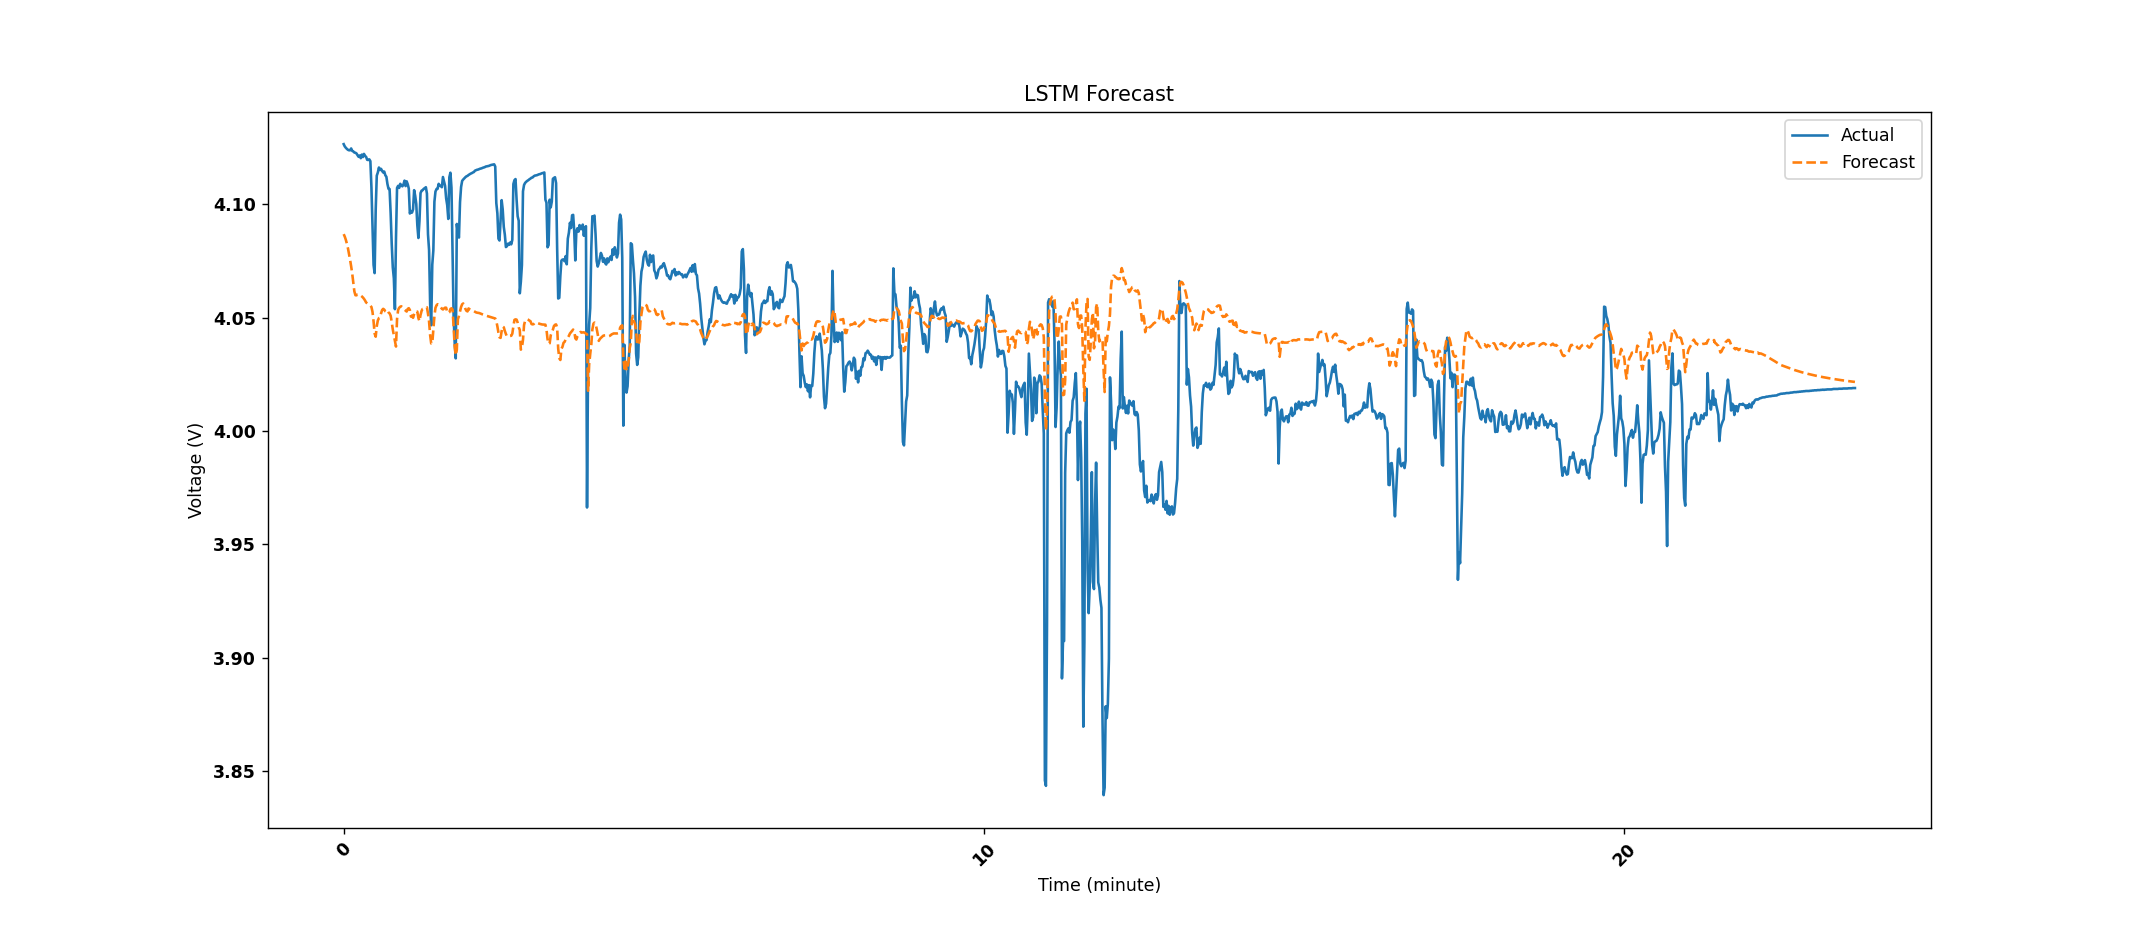

In [211]:
%matplotlib notebook
x_axis = np.arange(li_lstm_multivar_forecast.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'model_LSTM_mutivariate', 'lstm_multivar_model' + '.pdf')
# plot_predictions_with_transform(lstm_multivar, X, y, start=0, end=y.shape[0])  # prediction on training data
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (y_pred, "Forecast"))

### Simplified LSTM with less neurons and epochs

In [232]:
# Predict with LSTM
iteration_no = 0
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM_simpler', 'model' + str(iteration_no) + '.h5')

# forecast list
li_test_forecast = get_forecast_list(model_path, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
simple_lstm_forecast = np_test_forecast

<IPython.core.display.Javascript object>


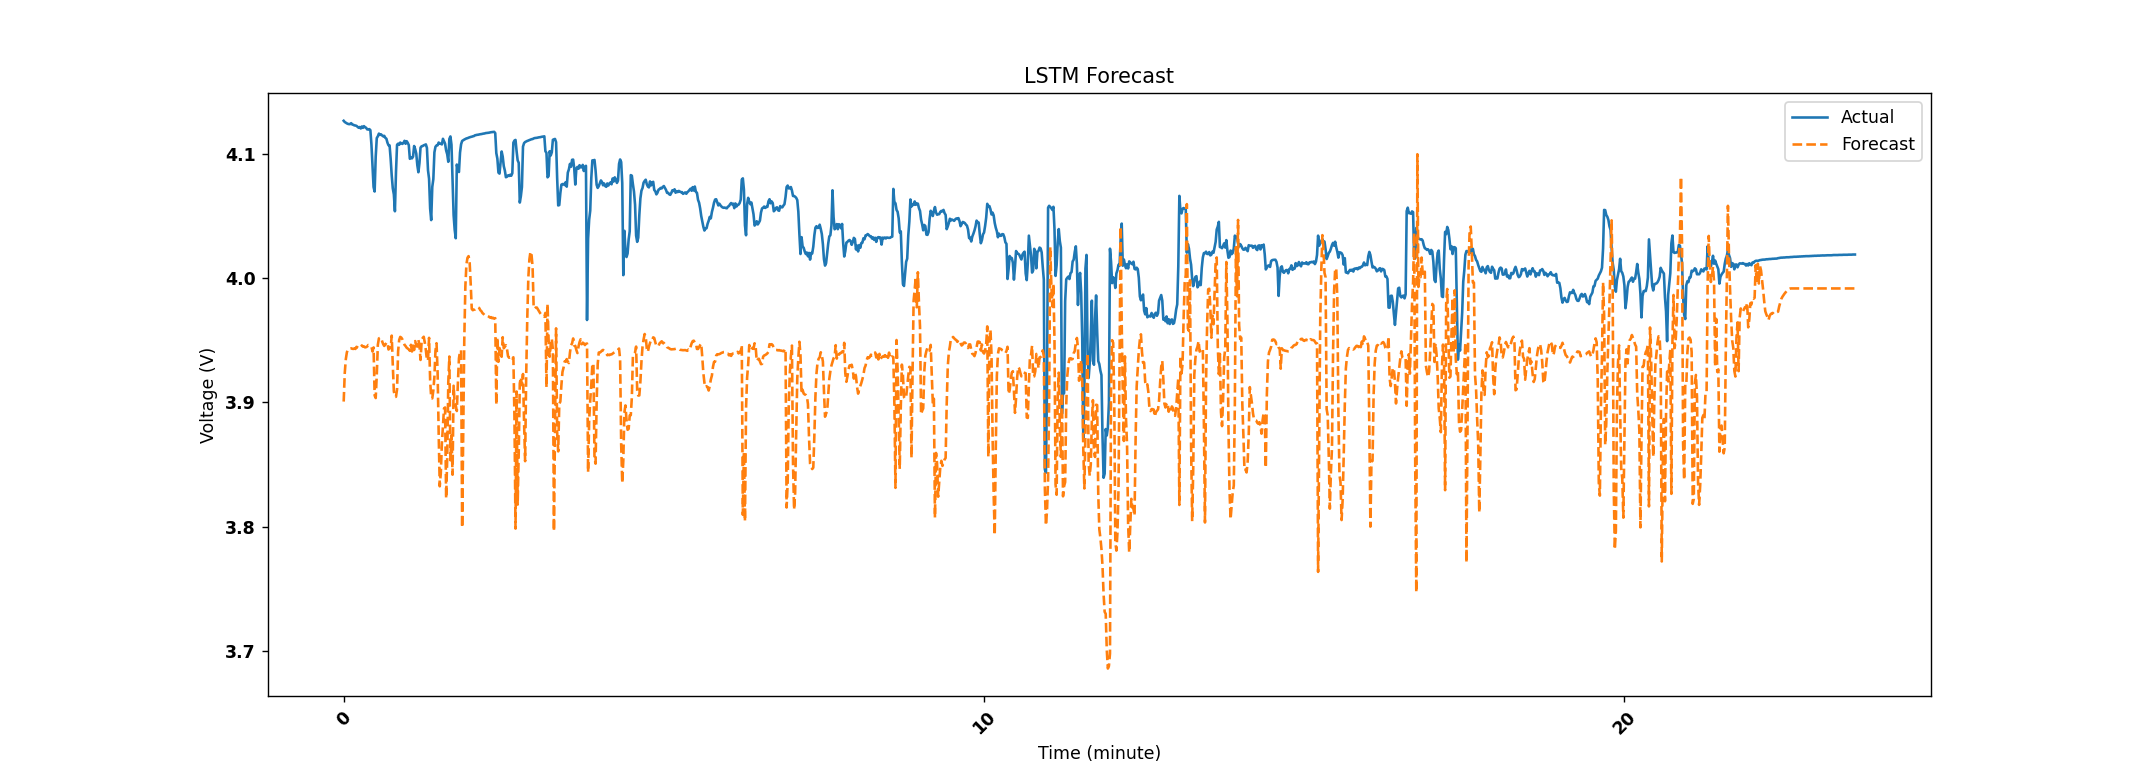

In [233]:
%matplotlib notebook
x_axis = np.arange(simple_lstm_forecast.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'generalized', 'LSTM_simpler', 'model' + str(iteration_no) + 'pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (simple_lstm_forecast, "Forecast"))

### LSTM bigger lookback = 20

In [235]:
df_test = li_train_cycles[2].copy()
TIMESTEPS = 20
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

# Predict with LSTM
iteration_no = 0
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM_bigger_lookback', 'model' + str(iteration_no) + '.h5')

# forecast list
li_test_forecast = get_forecast_list(model_path, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
lstm_bigger_lookback = np_test_forecast

<IPython.core.display.Javascript object>


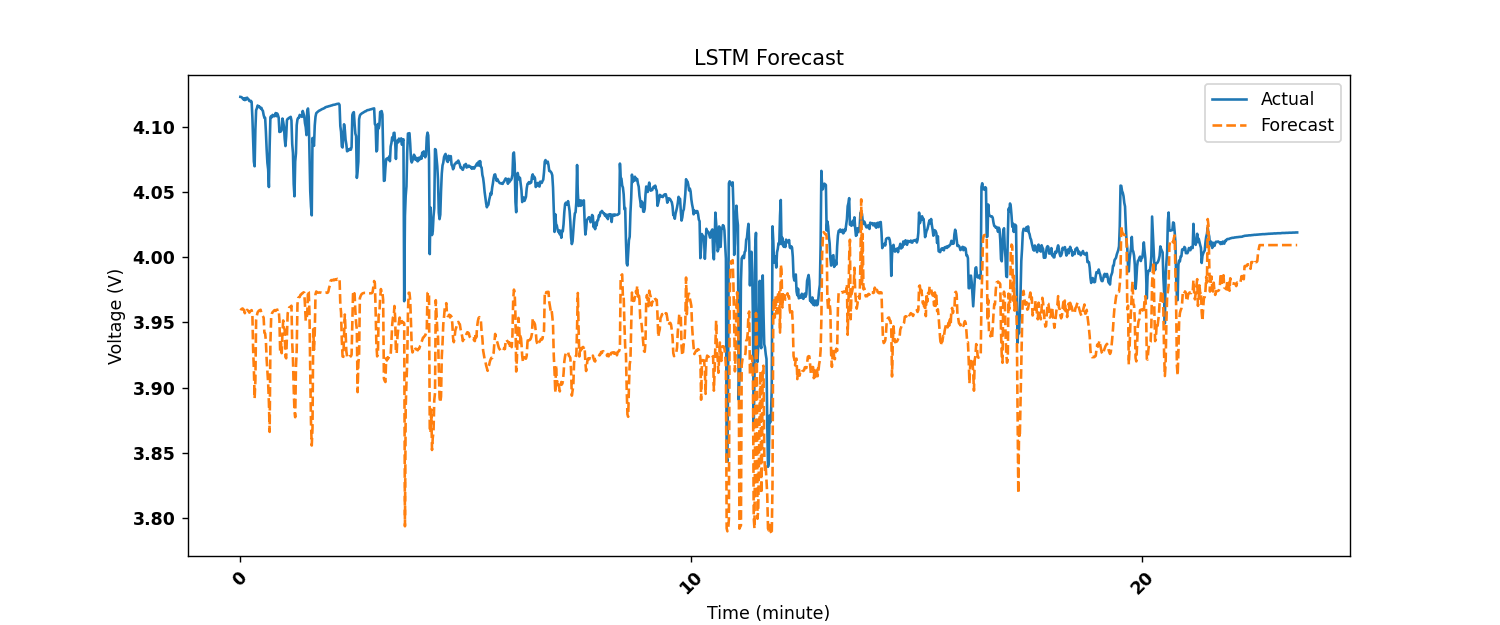

In [236]:
%matplotlib notebook
x_axis = np.arange(lstm_bigger_lookback.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'generalized', 'LSTM_bigger_lookback', 'model' + str(iteration_no) + '.pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (lstm_bigger_lookback, "Forecast"))

### LSTM scaled with high LR, timesteps=20

In [216]:
# Many to one supervised learning
TIMESTEPS = 20
train_X = []
train_y = []
for df in li_train_cycles:
    df_each = df.copy()
    df_each = df_each[['V', 'current', 'Temp']]   # only necessary columns
    X, y = df_to_supervised_multivariate(df_each.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

    # combine all the train cycles
    train_X += X.tolist()
    train_y += y.tolist()

train_X = np.array(train_X)   # convert to np array
train_y = np.array(train_y)


In [217]:
# Do min max normalization on global data and use them later for local TS use
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# train_X_scaled = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)

scalers = {}
X_scaled = train_X
for i in range(train_X.shape[1]):
    scalers[i] = MinMaxScaler()
    X_scaled[:, i, :] = scalers[i].fit_transform(train_X[:, i, :])
    
# for 1D array, simply use sklearn
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
train_y = train_y.reshape(-1, 1)                 # necessary for applying MinMaxScaler
scaler1 = scaler1.fit(train_y)
y_scaled = scaler1.transform(train_y)
y_scaled = y_scaled.flatten()        # Make array to 1D again


In [218]:
df_test = li_train_cycles[2].copy()
TIMESTEPS = 20
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y


In [219]:
# scale test data
# scalers = {}
test_X_scaled = X
for i in range(X.shape[1]):
    scalers[i] = MinMaxScaler()
    test_X_scaled[:, i, :] = scalers[i].fit_transform(X[:, i, :])

test_y = y.reshape(-1, 1)
test_y_scaled = scaler1.transform(test_y)
test_y_scaled = test_y_scaled.flatten()        # Make array to 1D again

# print(test_X_scaled)
# print(test_y_scaled)

In [220]:
# 1 step prediction
iteration_no = 1
FORECAST_SECONDS = len(df_test)

model_path = os.path.join(cwd, 'generalized', 'LSTM_scaled', 'model' + str(iteration_no) + '.h5')
from keras.models import load_model
model = load_model(model_path)

lstm_20 = model.predict(test_X_scaled)
lstm_20 = np.squeeze(lstm_20)
print(lstm_20.shape)

(1407,)


<IPython.core.display.Javascript object>


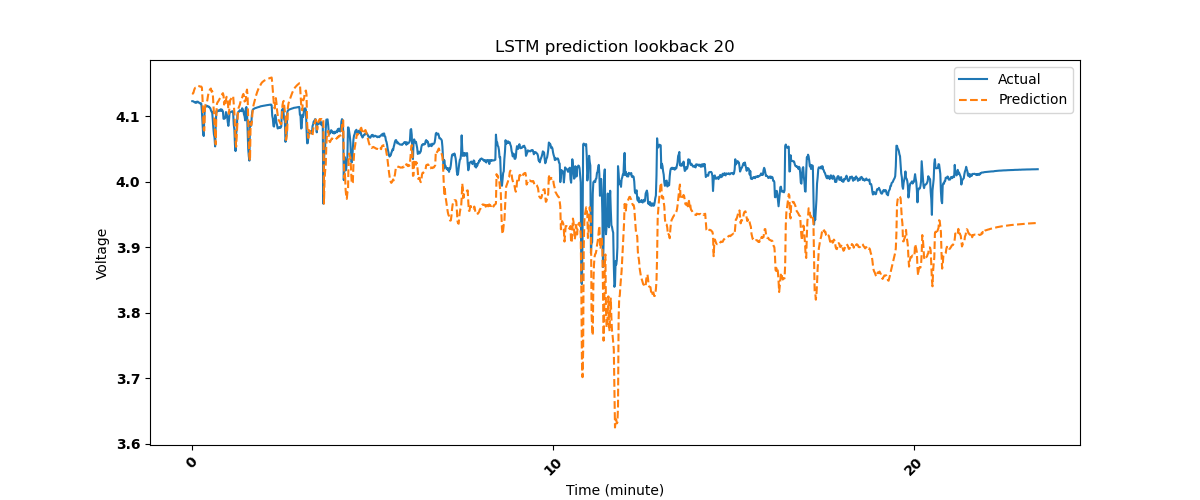

In [222]:
%matplotlib notebook
x_axis = np.arange(lstm_20.shape[0])
y = y[:FORECAST_SECONDS]

# inverse scale
y_pred_scaled = lstm_20.reshape(-1, 1)                 # necessary for applying MinMaxScaler
y_pred = scaler1.inverse_transform(y_pred_scaled)
y_pred = y_pred.flatten()
lstm_20 = y_pred

save_path = os.path.join(cwd, 'generalized', 'LSTM_scaled', 'model20' + str(iteration_no) + '.pdf')
custom_plot.plot_multi_line(("LSTM prediction lookback 20", save_path, "Voltage"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (y_pred, "Prediction"))

In [312]:
# Predict with LSTM
iteration_no = 0
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM_scaled', 'model' + str(iteration_no) + '.h5')

# forecast list
li_test_forecast = get_forecast_list(model_path, test_X_scaled, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
lstm_scaled = np_test_forecast

<IPython.core.display.Javascript object>


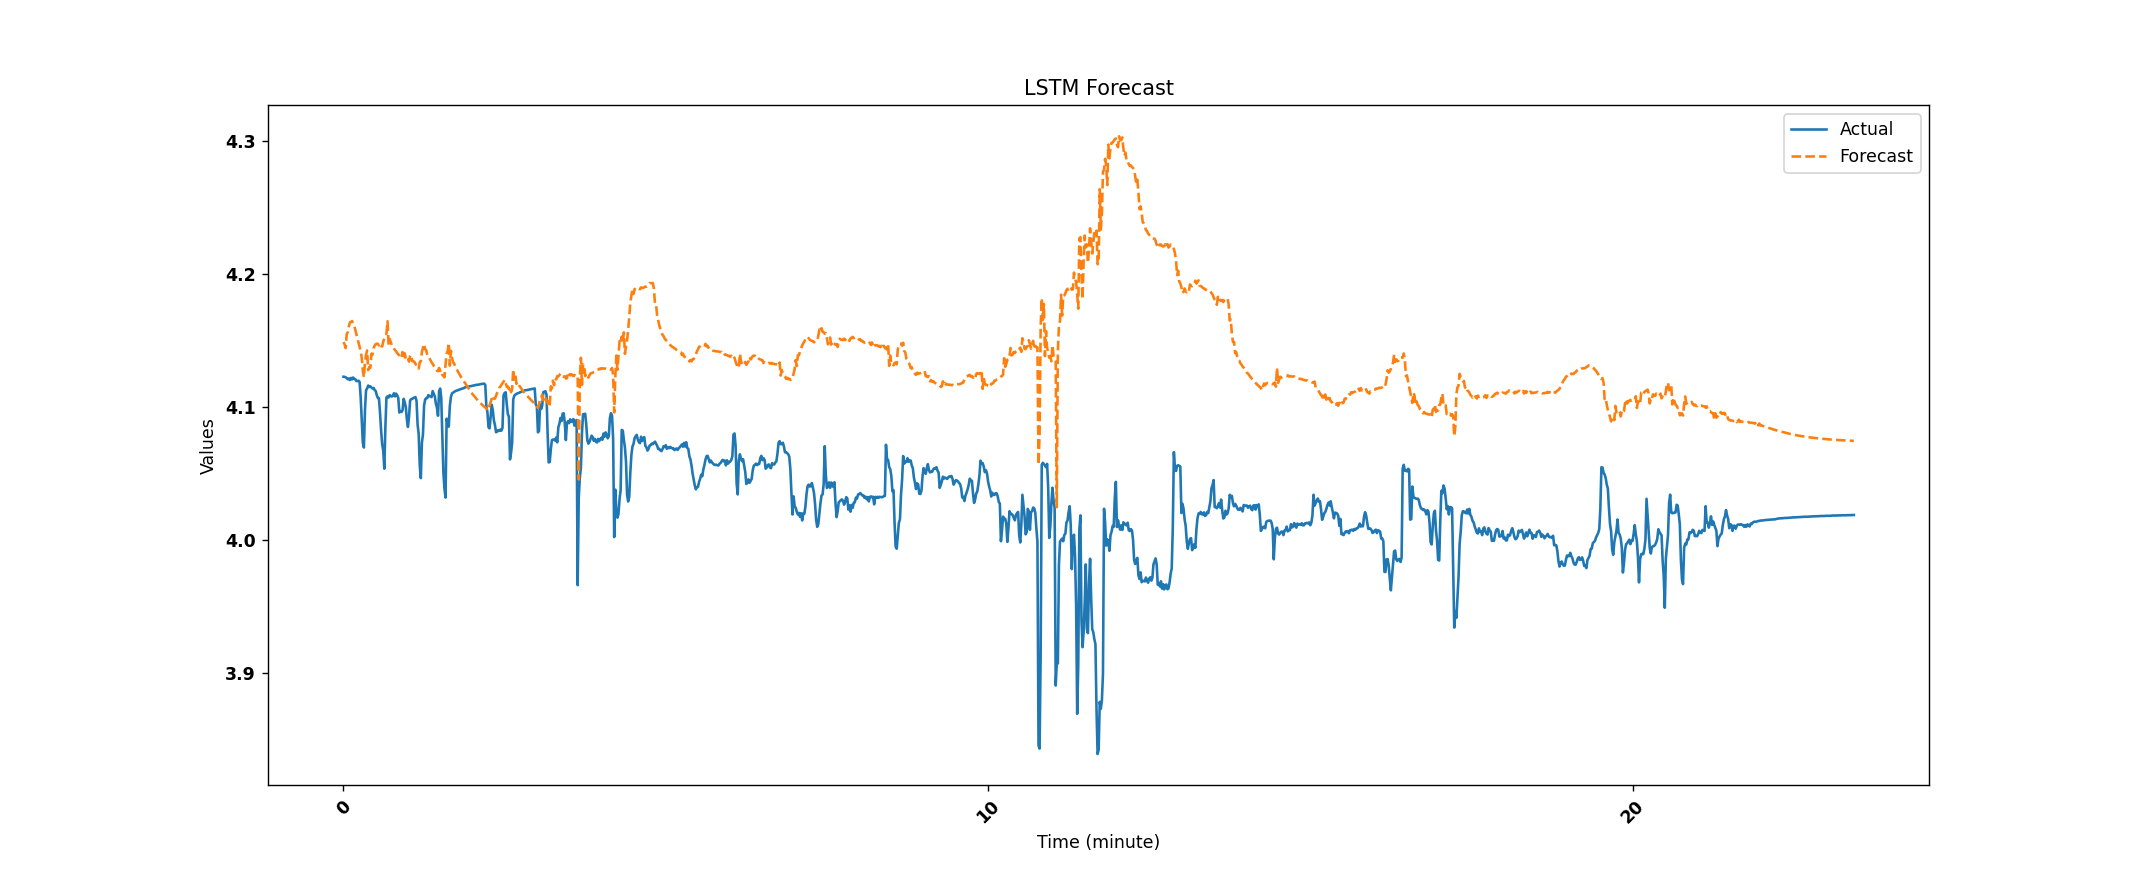

In [313]:
%matplotlib notebook
x_axis = np.arange(lstm_scaled.shape[0])
y = y[:FORECAST_SECONDS]

# inverse scale
y_pred_scaled = lstm_scaled.reshape(-1, 1)                 # necessary for applying MinMaxScaler
y_pred = scaler1.inverse_transform(y_pred_scaled)
y_pred = y_pred.flatten()


save_path = os.path.join(cwd, 'generalized', 'LSTM_scaled', 'model' + str(iteration_no) + '.pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Values"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (y_pred, "Forecast"))

### LSTM rms loss

In [289]:
df_test = li_train_cycles[2].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

In [290]:
# Predict with LSTM
iteration_no = 0
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM_rms', 'model' + str(iteration_no) + '.h5')

# forecast list
li_test_forecast = get_forecast_list(model_path, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
lstm_rms = np_test_forecast

<IPython.core.display.Javascript object>


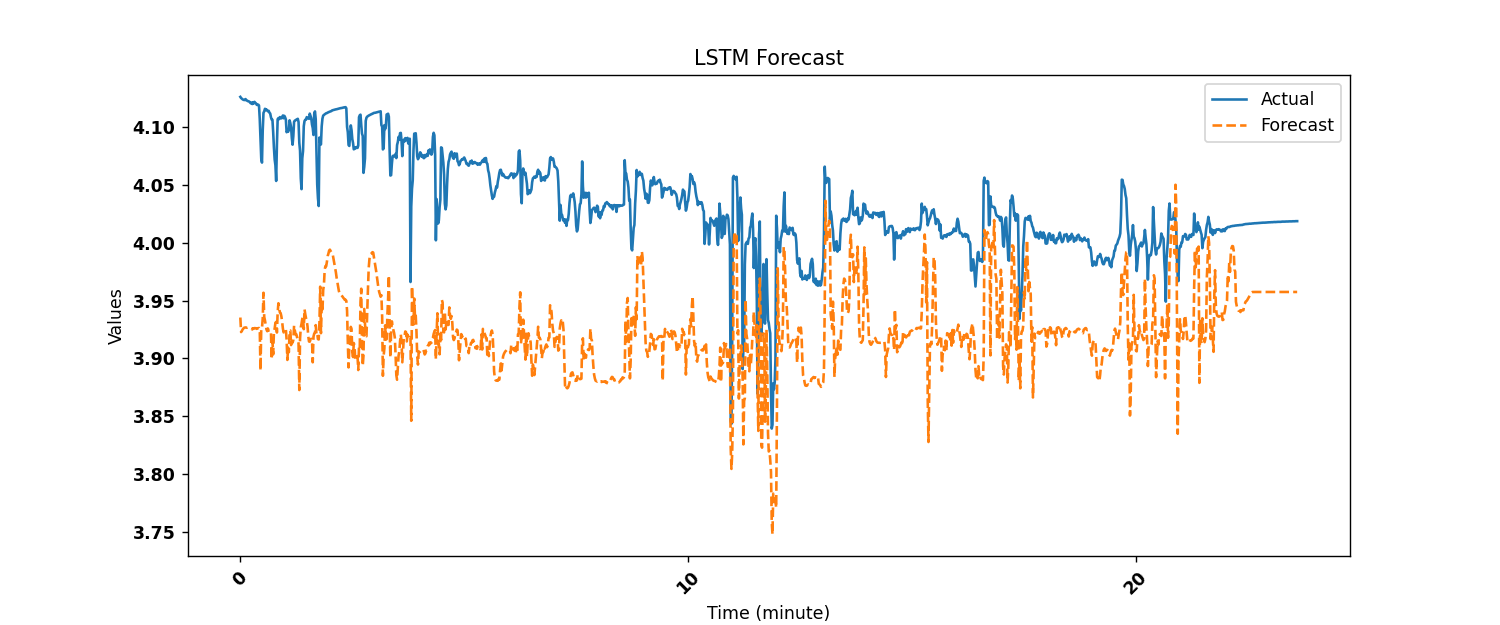

In [291]:
%matplotlib notebook
x_axis = np.arange(lstm_rms.shape[0])
y = y[:FORECAST_SECONDS]
save_path = os.path.join(cwd, 'generalized', 'LSTM_rms', 'model' + str(iteration_no) + '.pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Values"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (lstm_rms, "Forecast"))

### OCV forecast using current = 0 and rollling forecast 

In [264]:
# The only difference is that the input data now will have current=0 after the lookback

df_test = li_train_cycles[2].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
# print((df_test))
# Make three test cases where OCV forecast starts from different timestamps of the test
df_test1 = df_test.copy()
df_test1['current'].iloc[TIMESTEPS:] = 0     # set current=0 after timesteps
# print(df_test1)

df_test2 = df_test.copy()
df_test2 = df_test2.iloc[150:] # random starting point
df_test2['current'].iloc[TIMESTEPS:] = 0     # set current=0 after TIMESTEPS

df_test3 = df_test.copy()
df_test3 = df_test3.iloc[-500:] # Another random starting point
df_test3['current'].iloc[TIMESTEPS:] = 0     # set current=0 after TIMESTEPS

# Each
X1, y1 = df_to_supervised_multivariate(df_test1.to_numpy(), TIMESTEPS, 0)
X2, y2 = df_to_supervised_multivariate(df_test2.to_numpy(), TIMESTEPS, 0)
X3, y3 = df_to_supervised_multivariate(df_test3.to_numpy(), TIMESTEPS, 0)


In [262]:
# Predict with LSTM
iteration_no = 0
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM_simpler', 'model' + str(iteration_no) + '.h5')

# forecast OCV
li_test_forecast = get_forecast_list(model_path, X1, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
ocv_1 = np_test_forecast

li_test_forecast = get_forecast_list(model_path, X2, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
ocv_2 = np_test_forecast


In [265]:
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM_simpler', 'model' + str(iteration_no) + '.h5')
li_test_forecast = get_forecast_list(model_path, X3, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
ocv_3 = np_test_forecast

<IPython.core.display.Javascript object>


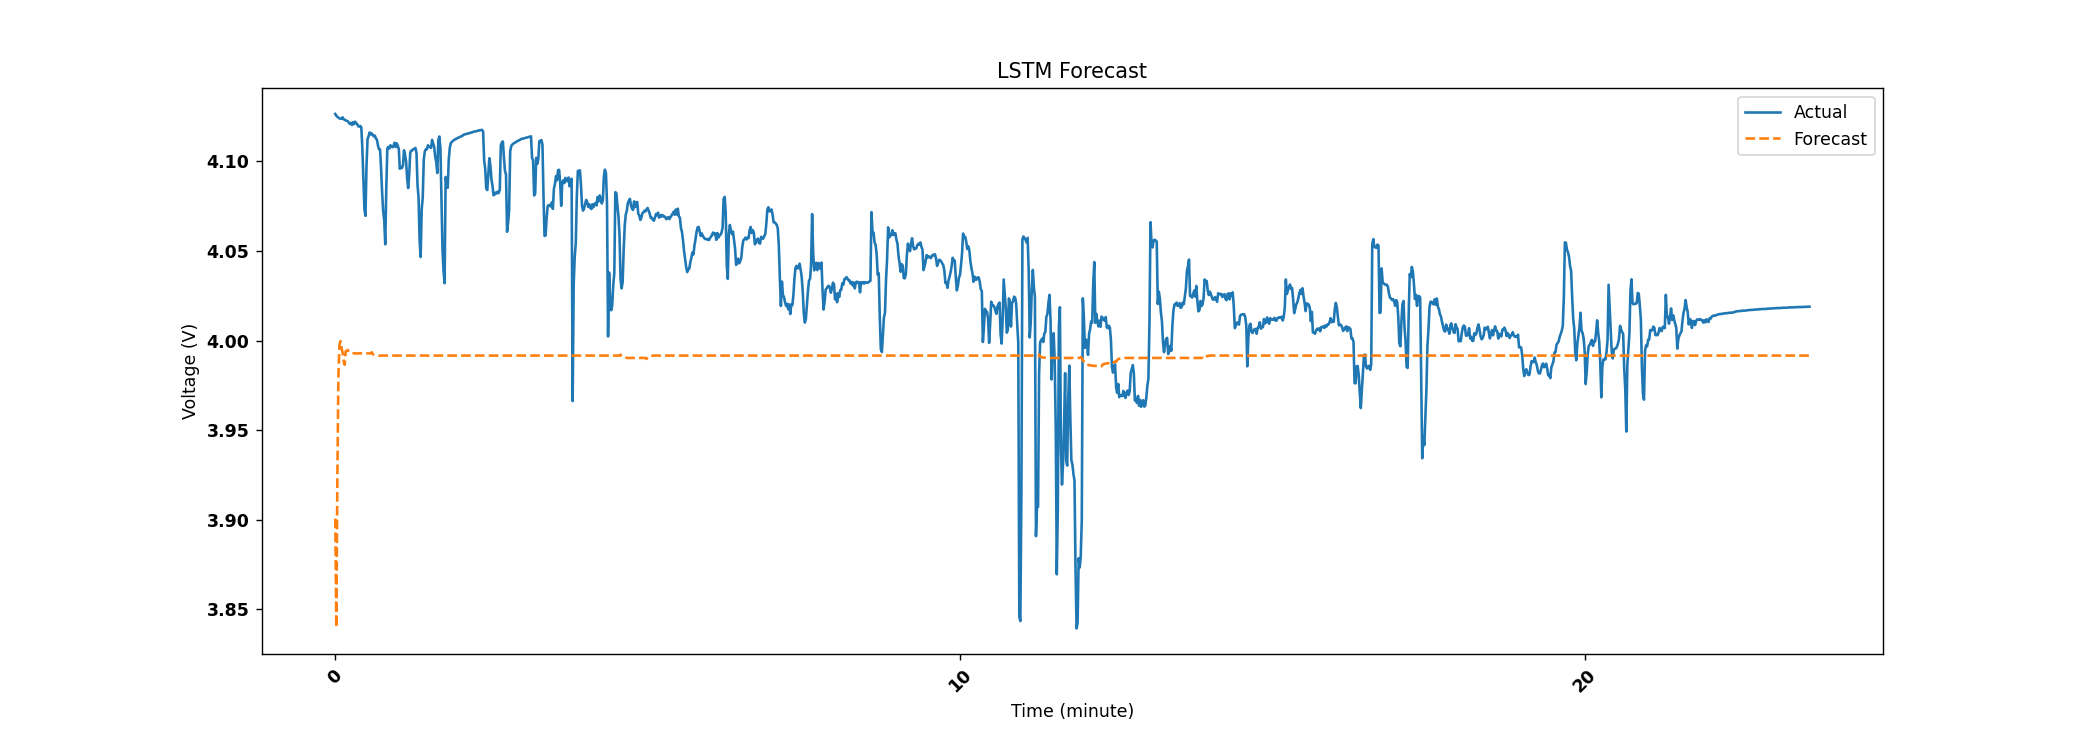

In [258]:
%matplotlib notebook
x_axis = np.arange(ocv_1.shape[0])
y = y1[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'generalized', 'LSTM_bigger_lookback', 'model' + str(iteration_no) + '_ocv1.pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (ocv_1, "Forecast"))

<IPython.core.display.Javascript object>


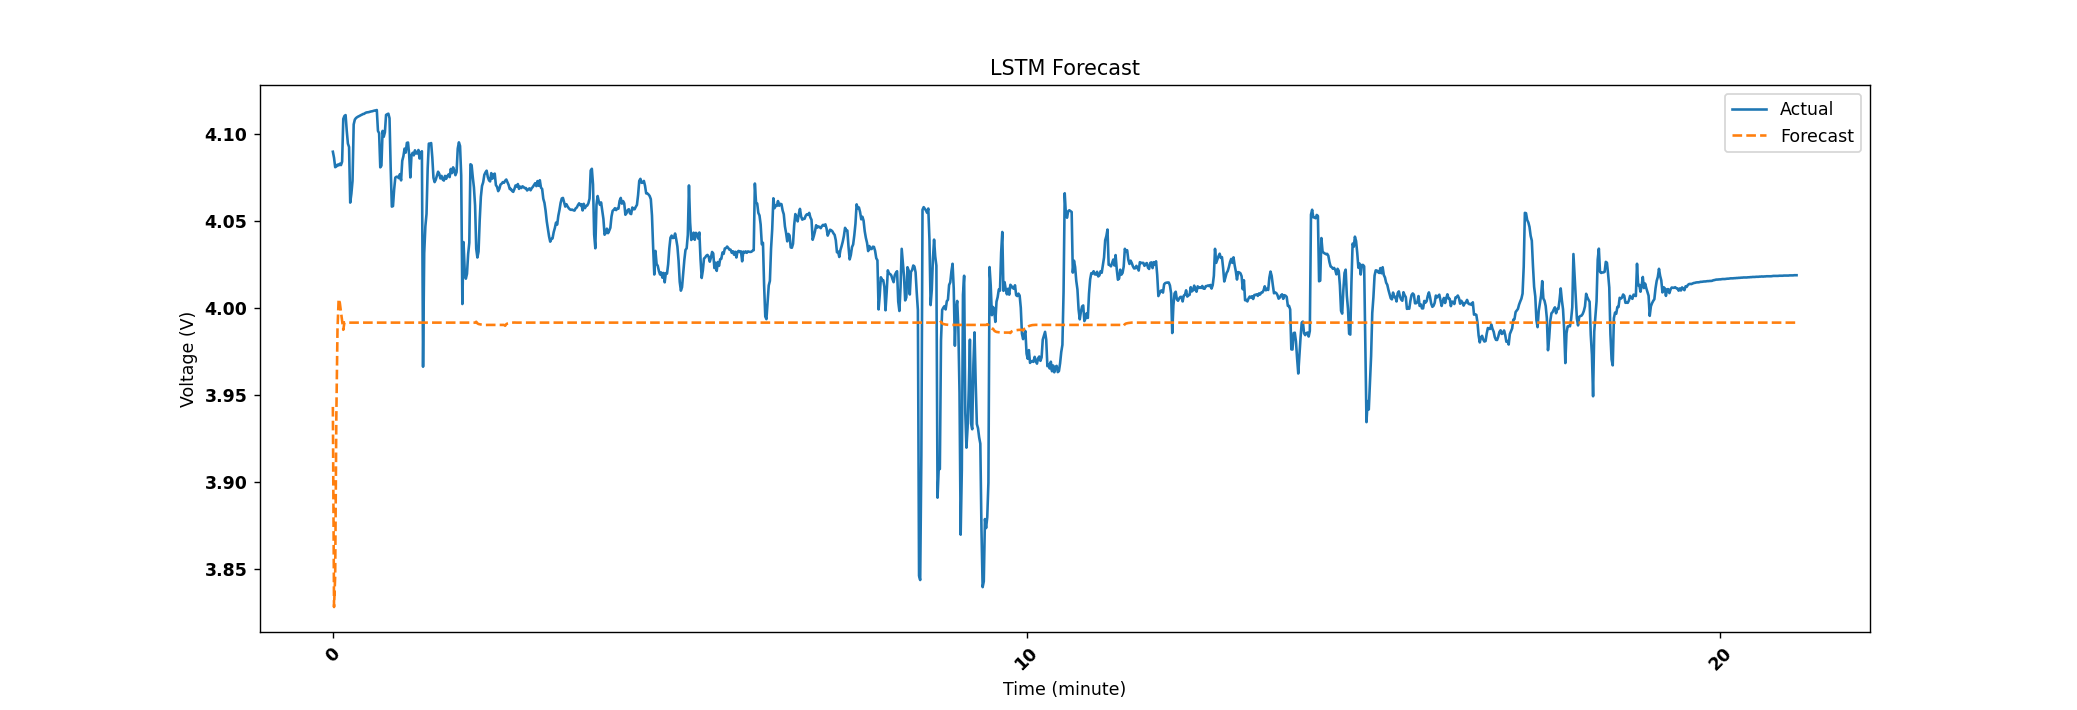

In [263]:
%matplotlib notebook
x_axis = np.arange(ocv_2.shape[0])
y = y2[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'generalized', 'LSTM_bigger_lookback', 'model' + str(iteration_no) + '_ocv2.pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (ocv_2, "Forecast"))

<IPython.core.display.Javascript object>


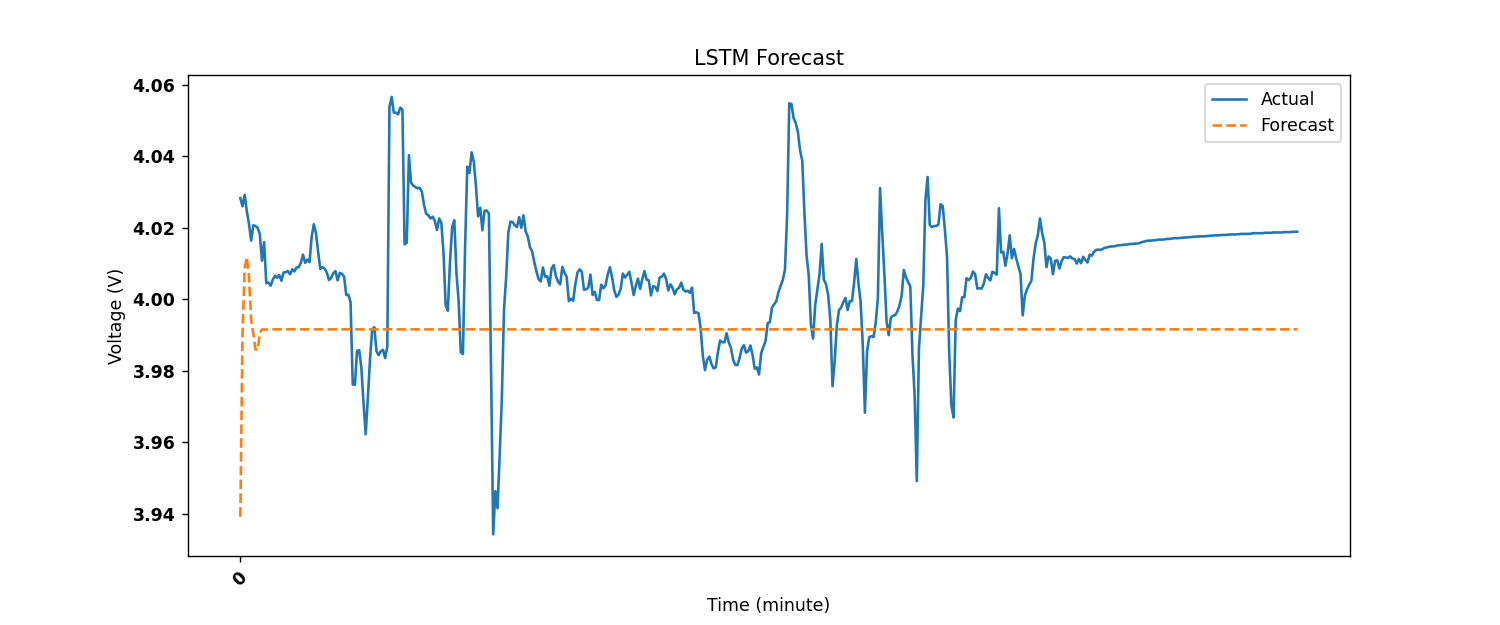

In [266]:
%matplotlib notebook
x_axis = np.arange(ocv_3.shape[0])
y = y3[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'generalized', 'LSTM_bigger_lookback', 'model' + str(iteration_no) + '_ocv2.pdf')
custom_plot.plot_multi_line(("LSTM Forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (ocv_3, "Forecast"))

## OCV-SOC curve for 94 Ah Samsung cell:

In [254]:
import matplotlib
# constants for plotting
ELAPSED_TIME = 0
TIMESTAMP = 1

def plot_multi_line(*axes):

    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

    matplotlib.rc('font', **font)
    fig = plt.figure(figsize =(8 ,5))

    # Set line style for different lines, 5 lines max
    li_linestyle = ["-", "--", "-.", ":", ' ']

    # assign argument values
    title, save_path, y_axis_label = axes[0]
    x_data, x_label = axes[1]
    
    # Gather all y axis labels and data
    for i in range(2, len(axes)):
        y_data, y_label = axes[i]
        # print(y_data, y_label)
        plt.plot(x_data, y_data, label = y_label, linestyle=li_linestyle[i-2])
#         print(len(axes), li_linestyle[i-2])

    # X label and Y label
    if (x_label == ELAPSED_TIME):
        scale_x = 60     # divide by 60 seconds
        li_ticks = np.arange(min(x_data), max(x_data)+1, 600)     # every 600 seconds = 10 minutes freq
        li_labels = list(map(lambda x: int(x/scale_x), li_ticks))      # 60 sec = 1 minutes
        plt.xticks(li_ticks, li_labels, rotation=45)
        plt.xlabel('Time (minute)')
    elif (x_label == TIMESTAMP):
        plt.xlabel('Datetime')
    else:
        plt.xlabel(x_label)
    plt.ylabel(y_axis_label)

    plt.title(title) # set the whole plot name
    plt.legend(bbox_to_anchor=(1.0, 1.0),prop={'size': 10,'weight' :'normal'})
    plt.show()
    fig.savefig(save_path)

0.3383838383838384 0.718434343434344


<IPython.core.display.Javascript object>


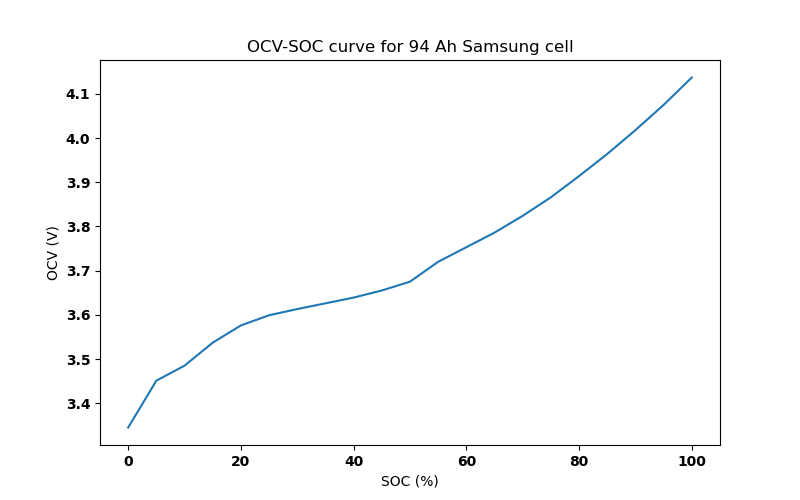

In [17]:
soc = [ 0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]
ocv = [ 3.345, 3.451, 3.485, 3.537, 3.576, 3.599, 3.613, 3.626, 3.639, 3.655, 3.675, 3.72, 3.753, 3.786, 3.824, 3.866, 3.914, 3.964, 4.018, 4.075, 4.137]


# voltage difference
#OCV  3.576   3.613   3.914
#SOC  20%      30%     80%
#diff 0.338   0.301

# total v diff = 0,792

# percentage = (value - min) / (max - min)
ocv_30 = (3.613 - 3.345) / (4.137 - 3.345)
ocv_80 = (3.914 - 3.345) / (4.137 - 3.345)
print(ocv_30, ocv_80)



save_path = os.path.join(cwd, 'figures', 'final' , 'ocv_soc.png')
plot_multi_line(("OCV-SOC curve for 94 Ah Samsung cell", save_path, "OCV (V)"), (soc, 'SOC (%)'), (ocv, "OCV"))

1493
2493


<IPython.core.display.Javascript object>


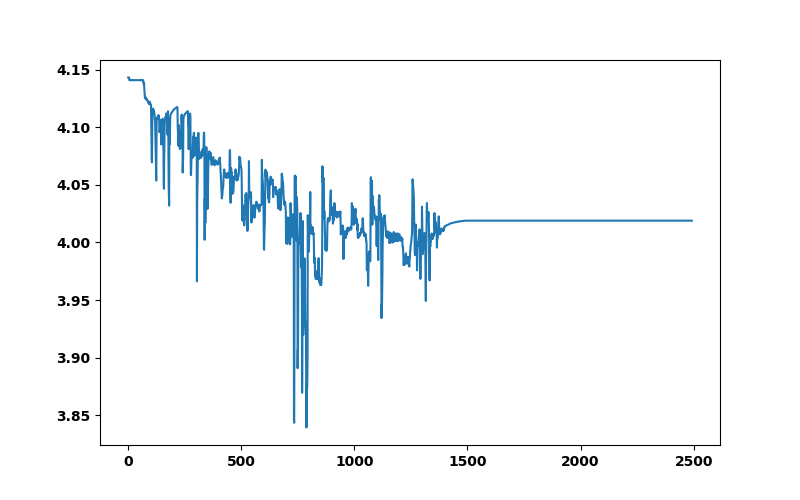

In [45]:
df_test = li_train_cycles[2].copy()
v_bms = df_test['V'].values    # convert to array
print(len(v_bms))
# v_bms = v_bms[1200:]
static_v = v_bms[-1]
v_bms = np.pad(v_bms, (0,1000), mode='constant', constant_values=static_v)          # padding seq: (left,right): here I am padding 1000 static voltage values only to the right
print(len(v_bms))
x_axis = np.arange(len(v_bms))

# Example drive cycle of Li-ion battery, V_BMS, Time(minutes)
save_path = os.path.join(cwd, 'figures', 'final' , 'ocv_drive_cycle.png')
plot_multi_line(("", save_path, ""), (x_axis, ''), (v_bms, ""))

### LSTM trained with stateful=true, Batch size 32

In [182]:
df_test = li_train_cycles[2].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

In [183]:
# Do min max normalization
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# train_X_scaled = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)

scalers = {}
X_scaled = X
for i in range(X.shape[1]):
    scalers[i] = MinMaxScaler()
    X_scaled[:, i, :] = scalers[i].fit_transform(X[:, i, :])

# for 1D array, simply use sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Y_data = y.reshape(-1, 1)                 # necessary for applying MinMaxScaler
scaler = scaler.fit(Y_data)
Y_scaled = scaler.transform(Y_data)
Y_scaled = Y_scaled.flatten()        # Make array to 1D again

In [184]:
# print(X_scaled)
# print(Y_scaled)
print(X_scaled.shape)
print(Y_scaled.shape)

(1417, 10, 3)
(1417,)


In [185]:
# Predict with LSTM
iteration_no = 0
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM_scaled', 'time_steps_10_batch', 'model' + str(iteration_no) + '.h5')

from keras.models import load_model
model = load_model(model_path)

# Copy weights for using different batch size
# re-define the batch size
BATCH_SIZE = 1
NUM_NEURONS = 64

# re-define model
new_model = Sequential()
new_model.add(LSTM(NUM_NEURONS, batch_input_shape=(BATCH_SIZE, X.shape[1], X.shape[2]), stateful=True))   # no use of batch because stateless, input shape=(#samples, #fatures)
new_model.add(Dense(8, 'relu'))
new_model.add(Dense(1, 'linear'))

# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)


In [186]:
# One step predition
# plot_predictions(new_model, X_scaled, Y_scaled, start=0, end=FORECAST_SECONDS)  # prediction on training data

# li_test_forecast = get_forecast_list(model_path, X, FORECAST_SECONDS, TIMESTEPS)
# np_test_forecast = np.array(li_test_forecast)
# lstm_stateful_batch = np_test_forecast
# print(testX)
y_pred = []
# Y_scaled

# online forecast
for i in range(Y_scaled.shape[0]):
    testX = X_scaled[i]
    testy = Y_scaled[i]
    testX = testX.reshape(BATCH_SIZE, X.shape[1], X.shape[2])
#     print(y[i])
#     print(testX.shape, testy.shape)
    yhat_arr = new_model.predict(testX, batch_size=BATCH_SIZE)
#     yhat_arr = new_model.predict(testX)        # no mentino of batch size
    yhat_arr = np.squeeze(yhat_arr)   # remove dimensions
    yhat = yhat_arr.item()            # get scalar
    y_pred.append(yhat)
#     print('>Expected=%.1f, Predicted=%.1f' % (testy, yhat))

In [187]:
y_pred_scaled = y_pred
# print(y_pred_scaled)

In [188]:
# inverse scale
y_pred = np.array(y_pred)          # must convert to np array before inverse scaling
y_pred = y_pred.reshape(-1, 1)                 # necessary for applying MinMaxScaler
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred.flatten()
print(len(y_pred), len(Y_scaled))

1417 1417


In [189]:
lstm_stateful = y_pred

<IPython.core.display.Javascript object>


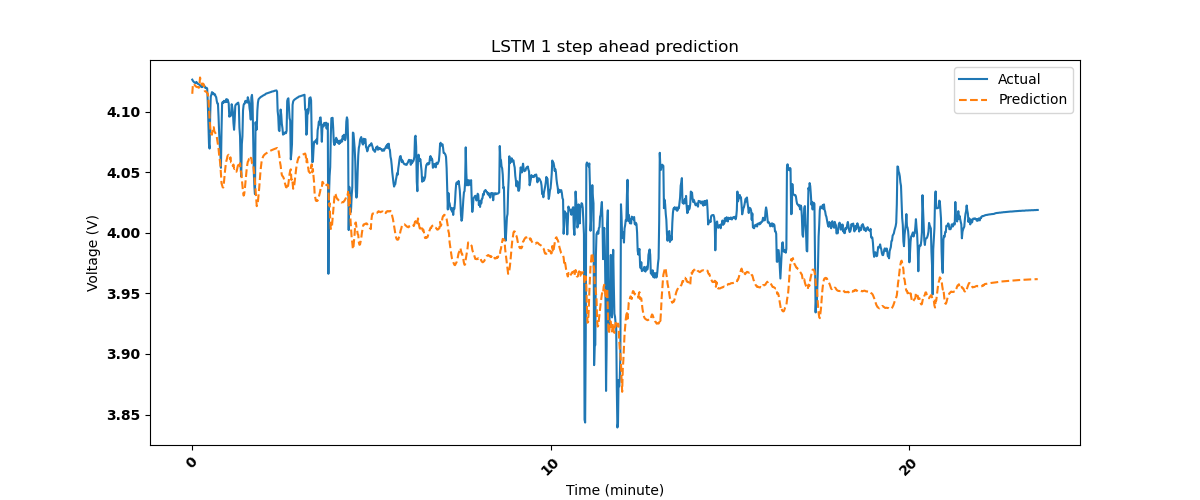

In [190]:
x_axis = np.arange(len(y))
save_path = os.path.join(cwd, 'generalized', 'LSTM_scaled', 'time_steps_10_batch', 'model' + str(iteration_no) + 'lstm_batch.pdf')
custom_plot.plot_multi_line(("LSTM 1 step ahead prediction", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (lstm_stateful, "Prediction"))

In [230]:
print(len(lstm_20))
print(len(rnn_predictions))
print(len(lstm_gen_predictions))
print(len(lstm_stateful))
print(len(y))
print(type(lstm_20))
first_val = lstm_20[0]
lstm_20_processed = np.pad(lstm_20, (10, 0), mode='constant', constant_values=first_val)          # padding seq: (left,right): here I am padding 10 values to the left
 (lstm_20_processed, "LSTM (lookback=20)")

1407
1417
1417
1417
1417
<class 'numpy.ndarray'>


### comparison among model performance

<IPython.core.display.Javascript object>


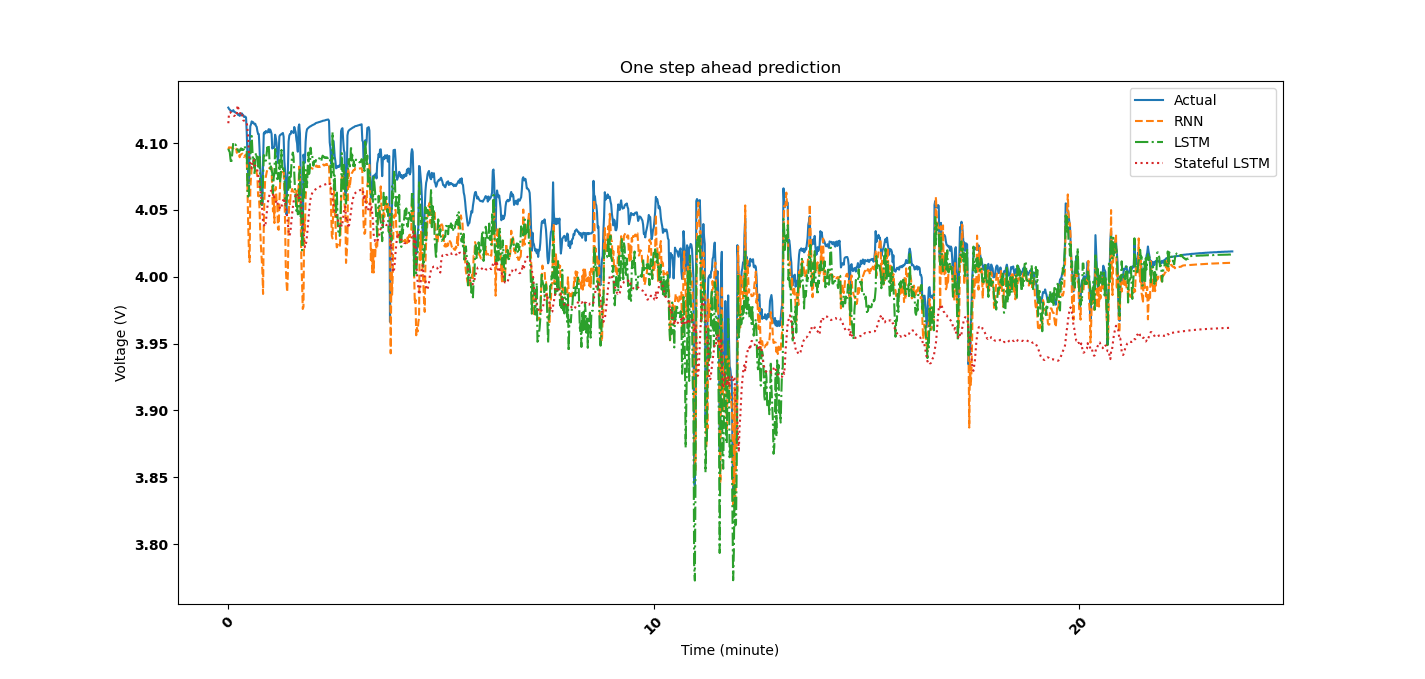

In [257]:
# One step ahead prediction

x_axis = np.arange(len(y))

save_path = os.path.join(cwd, 'one_step_pred_compare.png')
plot_multi_line(("One step ahead prediction", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (rnn_predictions, "RNN"), (lstm_gen_predictions, "LSTM"), (lstm_stateful, "Stateful LSTM"))

In [261]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

print("RNN RMSE: ", mse(y, rnn_predictions, squared=False))
# print("MAE: ", mae(y, rnn_predictions))
print("RNN MAPE: ", mape(y, rnn_predictions))

print("LSTM RMSE: ", mse(y, lstm_gen_predictions, squared=False))
print("LSTM MAPE: ", mape(y, lstm_gen_predictions))

print("Stateful LSTM RMSE: ", mse(y, lstm_stateful, squared=False))
print("Stateful MAPE: ", mape(y, lstm_stateful))

print("20 LSTM RMSE: ", mse(y, lstm_20_processed, squared=False))
print("20 MAPE: ", mape(y, lstm_20_processed))

# Error for 1 step ahead prediction
# lstm_20
# rnn_predictions
# lstm_gen_predictions
# lstm_stateful

RNN RMSE:  0.03046875265774442
RNN MAPE:  0.006315938608582819
LSTM RMSE:  0.03244238135572559
LSTM MAPE:  0.006524727911923947
Stateful LSTM RMSE:  0.05486463593842186
Stateful MAPE:  0.012892144667462005
20 LSTM RMSE:  0.08087560454939295
20 MAPE:  0.017294650911462452


### rolling forecast

<IPython.core.display.Javascript object>


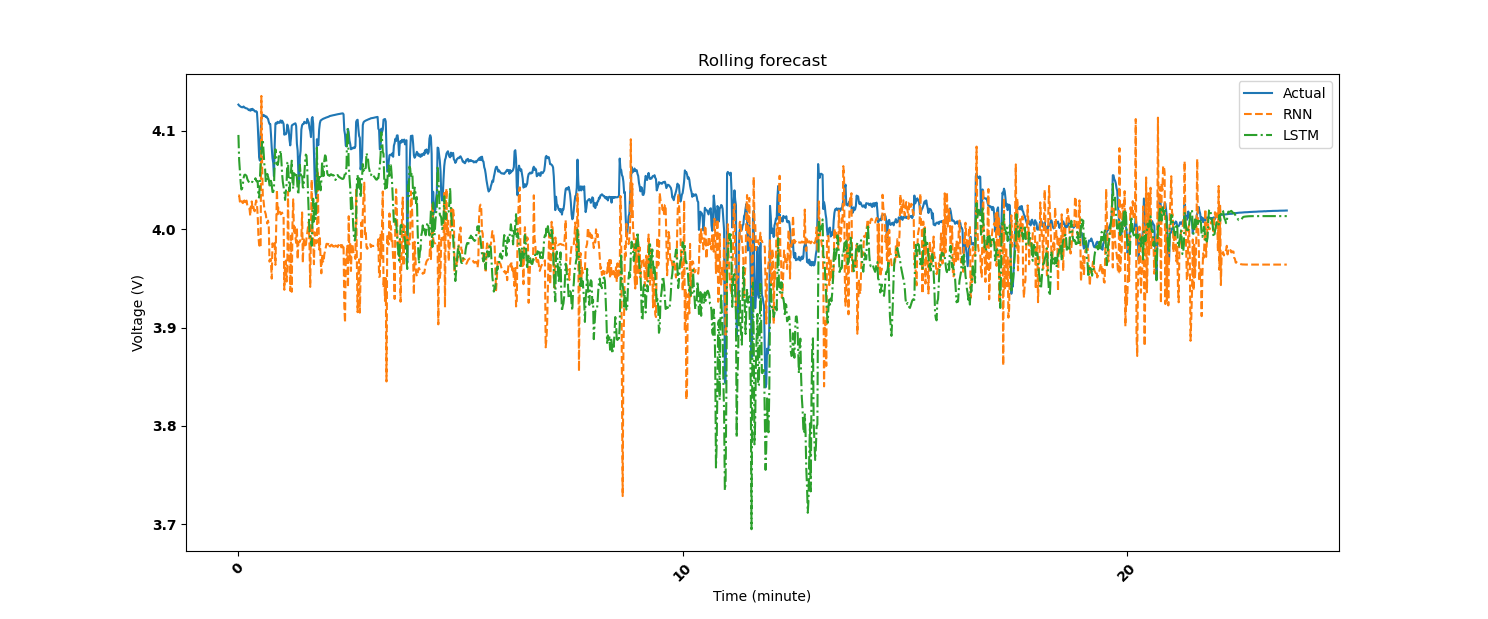

In [268]:
x_axis = np.arange(len(y))

save_path = os.path.join(cwd, 'rolling_forecast_compare.pdf')
plot_multi_line(("Rolling forecast", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (rnn_forecast, "RNN"), (lstm_forecast, "LSTM"))

In [269]:
# error
print("RNN forecast RMSE: ", mse(y, rnn_forecast, squared=False))
print("RNN forecast MAPE: ", mape(y, rnn_forecast))

print("LSTM forecast RMSE: ", mse(y, lstm_forecast, squared=False))
print("LSTM forecast MAPE: ", mape(y, lstm_forecast))

RNN forecast RMSE:  0.07361534732505959
RNN forecast MAPE:  0.01487950411604014
LSTM forecast RMSE:  0.06995775615899968
LSTM forecast MAPE:  0.014130911231756903


### Input freezing

In [290]:
# The only difference is that the input data now will have current=0 after the lookback

df_test = li_train_cycles[2].copy()
TIMESTEPS = 10

iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns

# Make three test cases where OCV forecast starts from different timestamps of the test
df1 = df_test.copy()
df1['current'].iloc[TIMESTEPS:] = 0     # set current=0 after timesteps

df2 = df_test.copy()
df2['current'].iloc[150:] = 0     # set current=0 after 150

df3 = df_test.copy()
df3['current'].iloc[400:] = 0     # set current=0 after 400 steps

df4 = df_test.copy()
df4 = df4[700:]
df4['current'].iloc[TIMESTEPS:] = 0     # set current=0 after TIMESTEPS

df5 = df_test.copy()
df5['current'].iloc[1000:] = 0     # set current=0 after TIMESTEPS

df6 = df_test.copy()
df7 = df7[1200:]
df6['current'].iloc[TIMESTEPS:] = 0     # set current=0 after TIMESTEPS

df7 = df_test.copy()
df7 = df7[1500:]
df7['current'].iloc[1500:] = 0     # set current=0 after TIMESTEPS

# Each
X1, y1 = df_to_supervised_multivariate(df1.to_numpy(), TIMESTEPS, 0)
X2, y2 = df_to_supervised_multivariate(df2.to_numpy(), TIMESTEPS, 0)
X3, y3 = df_to_supervised_multivariate(df3.to_numpy(), TIMESTEPS, 0)
X4, y4 = df_to_supervised_multivariate(df4.to_numpy(), TIMESTEPS, 0)
X5, y5 = df_to_supervised_multivariate(df5.to_numpy(), TIMESTEPS, 0)
X6, y6 = df_to_supervised_multivariate(df6.to_numpy(), TIMESTEPS, 0)
X7, y7 = df_to_supervised_multivariate(df7.to_numpy(), TIMESTEPS, 0)
print(len(df6), len(df3))

1427 1427


In [279]:
# Predict with LSTM
iteration_no = 1
FORECAST_SECONDS = len(df_test)
model_path = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(iteration_no) + '.h5')

# forecast OCV
li_test_forecast = get_forecast_list(model_path, X1, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
ocv_1 = np_test_forecast



IndexError: tuple index out of range

In [291]:
li_test_forecast = get_forecast_list(model_path, X4, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
ocv_4 = np_test_forecast

In [292]:
li_test_forecast = get_forecast_list(model_path, X6, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
ocv_6 = np_test_forecast

In [297]:
model_path = os.path.join(cwd, 'generalized', 'LSTM', 'model' + str(iteration_no) + '.h5')
from keras.models import load_model
model = load_model(model_path)


In [299]:
ocv_6 = model.predict(X6)
ocv_6_predictions = np.squeeze(lstm_gen_predictions)

In [280]:
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)

In [ ]:
for i in y

<IPython.core.display.Javascript object>


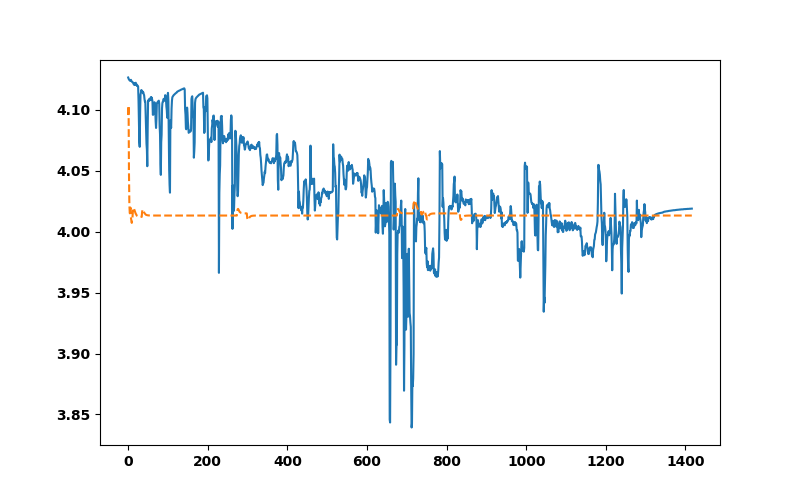

ValueError: x and y must have same first dimension, but have shapes (1417,) and (717,)

In [293]:
# OCV forecast
x_axis = np.arange(len(y))

save_path = os.path.join(cwd, 'one_step_pred_compare.png')
plot_multi_line(("OCV at random points", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (ocv_1, "OCV1"), (ocv_4, "OCV2"), (ocv_6, "OCV3"))

<IPython.core.display.Javascript object>


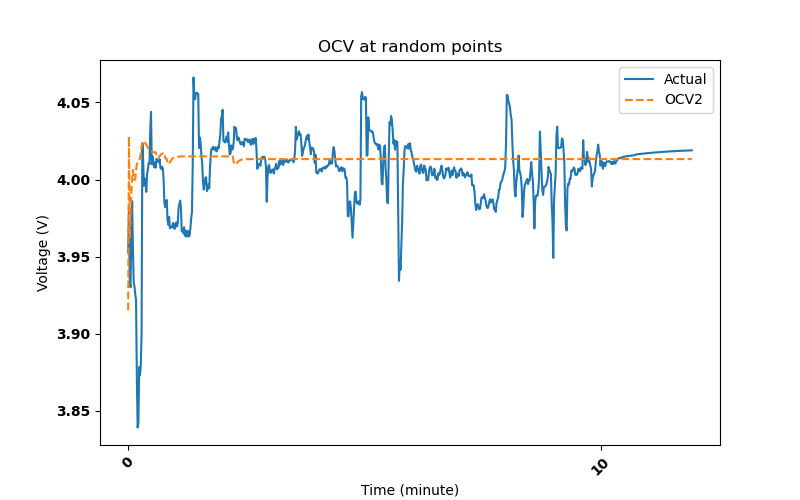

In [295]:
y4 = y[700:]
x_axis = np.arange(len(y4))

save_path = os.path.join(cwd, 'one_step_pred_compare.png')
plot_multi_line(("OCV at random points", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y4, "Actual"), (ocv_4, "OCV2"))

In [301]:
# y6 = y[1200:]

x_axis = np.arange(len(ocv_6_predictions.shape[0]))

save_path = os.path.join(cwd, 'one_step_pred_compare.png')
plot_multi_line(("OCV at random points", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y6, "Actual"), (ocv_6_predictions, "OCV2"))

TypeError: object of type 'int' has no len()

In [276]:
# OCV-SOC curve
df_test = li_train_cycles[2].copy()
print(df_test)

                 timestamp  current  min_SOC  cur_integral_module1  \
695111 2022-02-22 22:32:06      0.0   100.00                   0.0   
695112 2022-02-22 22:32:07      0.0   100.00                   0.0   
695113 2022-02-22 22:32:08      0.0   100.00                   0.0   
695114 2022-02-22 22:32:09      0.0   100.00                   0.0   
695115 2022-02-22 22:32:10      0.0   100.00                   0.0   
...                    ...      ...      ...                   ...   
696599 2022-02-22 22:56:54      0.0    90.48              -31900.0   
696600 2022-02-22 22:56:55      0.0    90.48              -31900.0   
696601 2022-02-22 22:56:56      0.0    90.48              -31900.0   
696602 2022-02-22 22:56:57      0.0    90.48              -31900.0   
696603 2022-02-22 22:56:58      0.0    90.48              -31900.0   

        contactor_state  contactor_off_time       V   Temp  elapsed_sec  
695111              0.0              1853.0  4.1432  14.25          0.0  
695112     

### coulomb counting vs OCV forecast

<IPython.core.display.Javascript object>


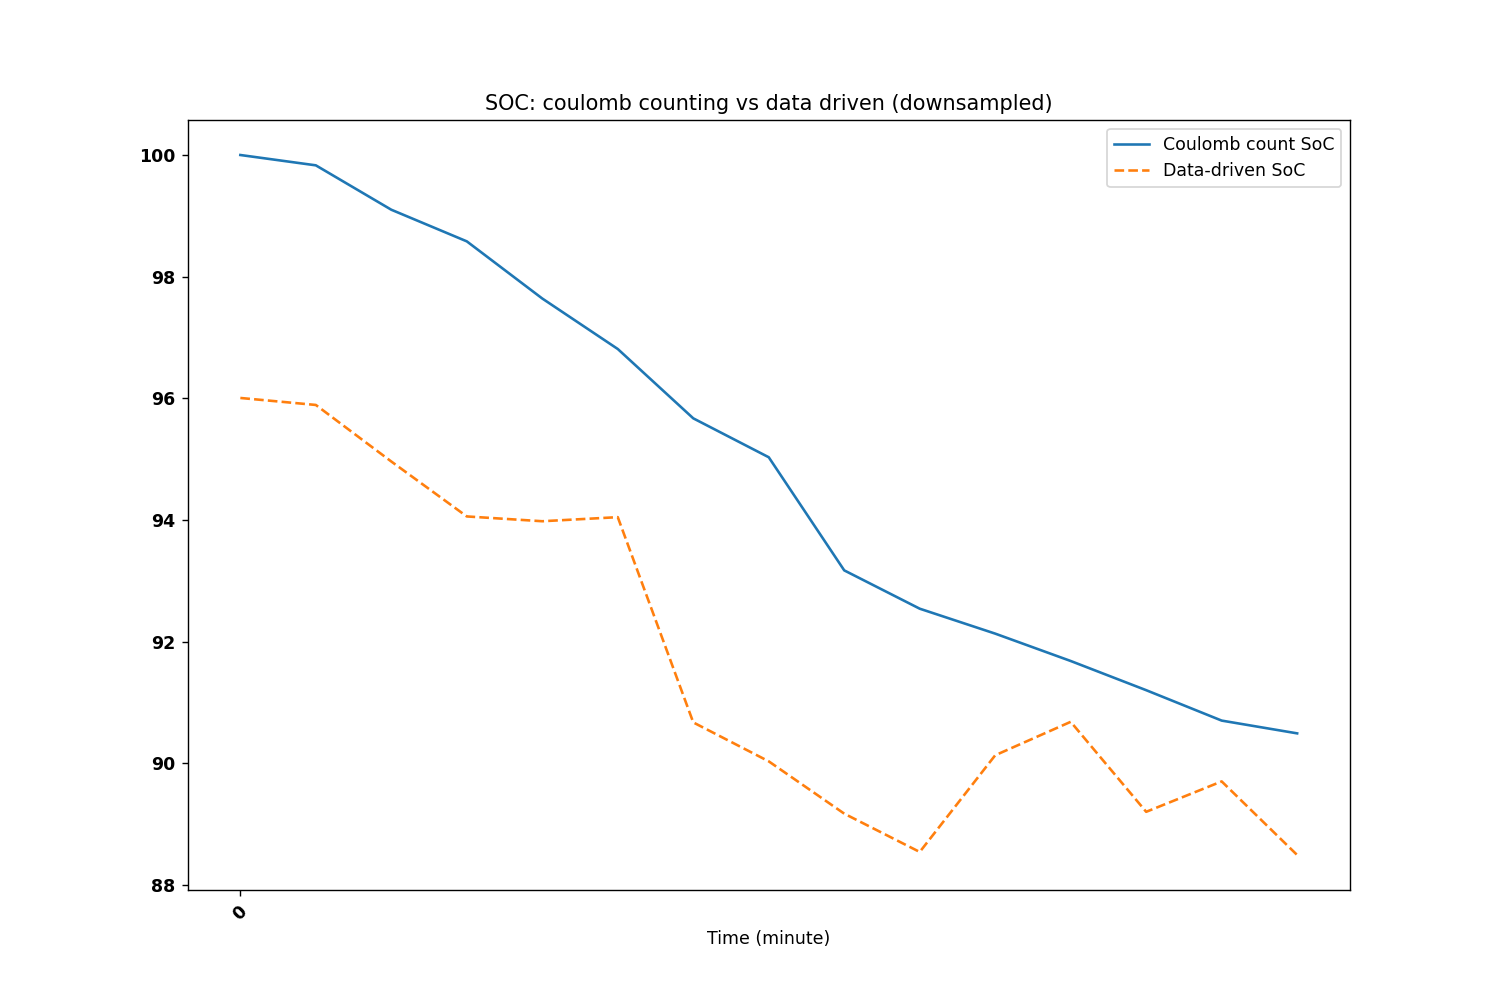

In [48]:

df_test = li_train_cycles[2].copy()
li_SOC = df_test['min_SOC'].tolist()
li_bms_soc = li_SOC[0::100]
li_ocv = [4.02, 4.018, 3.912, 4.018, 97.64, 96.81, 95.67, 95.03, 93.17, 92.54, 92.13, 91.68, 91.2, 90.7, 88.49]
li_soc_from_lut = [96.005, 95.89, 94.96, 94.057, 93.978, 94.045, 90.67, 90.03, 89.17, 88.54, 90.13, 90.68, 89.2, 89.7, 88.49]
# print(li_ds_soc)

# lut values
# soc = [ 0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]
# ocv = [ 3.345, 3.451, 3.485, 3.537, 3.576, 3.599, 3.613, 3.626, 3.639, 3.655, 3.675, 3.72, 3.753, 3.786, 3.824, 3.866, 3.914, 3.964, 4.018, 4.075, 4.137]
x_axis = np.arange(len(li_bms_soc))

save_path = os.path.join(cwd, 'figures', 'soc_compare.pdf')
plot_multi_line(("SOC: coulomb counting vs data driven (downsampled)", save_path, "SOC (%)"), (x_axis, "Time"), (li_bms_soc, "Coulomb count SoC"), (li_soc_from_lut, "Data-driven SoC"))

### GRU prediction

In [108]:
df_test = li_train_cycles[2].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

In [119]:
# Predict with GRU
iteration_no = 0
FORECAST_SECONDS = len(df_test)

from tensorflow.keras.models import load_model
model_gru = tf.keras.models.load_model('model_GRU/')

# forecast list
li_test_forecast = get_forecast_list(model_gru, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
gru = np_test_forecast

<IPython.core.display.Javascript object>


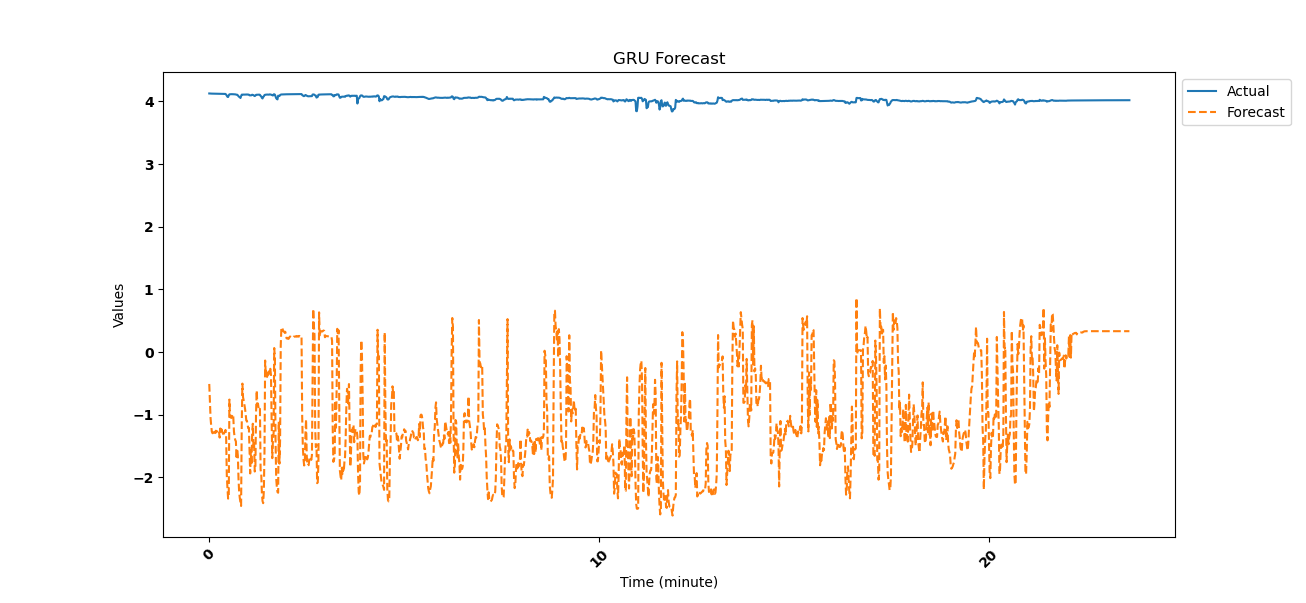

In [120]:
%matplotlib notebook
x_axis = np.arange(gru.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'model_GRU', 'model' + str(iteration_no) + '.pdf')
custom_plot.plot_multi_line(("GRU Forecast", save_path, "Values"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (gru, "Forecast"))

### Conv

In [121]:
df_test = li_train_cycles[2].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

In [122]:
# Predict with LSTM_CONV
iteration_no = 0
FORECAST_SECONDS = len(df_test)

from tensorflow.keras.models import load_model
model_conv = tf.keras.models.load_model('model_conv/')

# forecast list
li_test_forecast = get_forecast_list(model_gru, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
conv = np_test_forecast

<IPython.core.display.Javascript object>


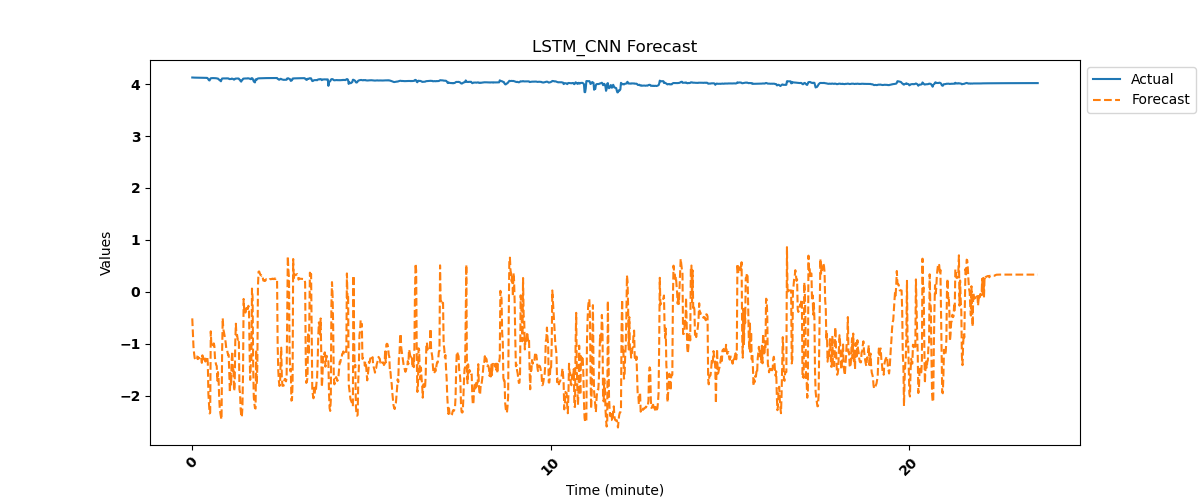

In [123]:
%matplotlib notebook
x_axis = np.arange(conv.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'model_conv', 'model' + str(iteration_no) + '.pdf')
custom_plot.plot_multi_line(("LSTM_CNN Forecast", save_path, "Values"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (conv, "Forecast"))

### Univariate LSTM model: only voltage

In [131]:
df_test = li_train_cycles[2].copy()
TIMESTEPS = 10
# print(len(df_test))
iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test[['V', 'current', 'Temp']]   # only voltage
X, y = df_to_supervised_multivariate(df_test.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

In [128]:
# # Predict with LSTM_CONV
# iteration_no = 0
# FORECAST_SECONDS = len(df_test)

# from tensorflow.keras.models import load_model
# # lstm_uni = tf.keras.models.load_model('lstm_univar_window10/')
# lstm_uni = load_model('lstm_univar_window10/model.04-0.00.h5')

# # model_path = os.path.join(cwd, 'lstm_univar_window10', 'model.01-0.00.h5.h5')

# # forecast list
# li_test_forecast = get_forecast_list(lstm_uni, X, FORECAST_SECONDS, TIMESTEPS)
# np_test_forecast = np.array(li_test_forecast)
# lstm_uni = np_test_forecast

In [132]:
# Predict with LSTM_CONV
iteration_no = 0
FORECAST_SECONDS = len(df_test)

from tensorflow.keras.models import load_model
# lstm_uni = tf.keras.models.load_model('lstm_univar_window10/')
lstm_model1 = load_model('model1/')

# model_path = os.path.join(cwd, 'lstm_univar_window10', 'model.01-0.00.h5.h5')

# forecast list
li_test_forecast = get_forecast_list(lstm_model1, X, FORECAST_SECONDS, TIMESTEPS)
np_test_forecast = np.array(li_test_forecast)
lstm_model1 = np_test_forecast

ValueError: in user code:

    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\s.kaiser\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 5, 1), found shape=(None, 10, 3)


<IPython.core.display.Javascript object>


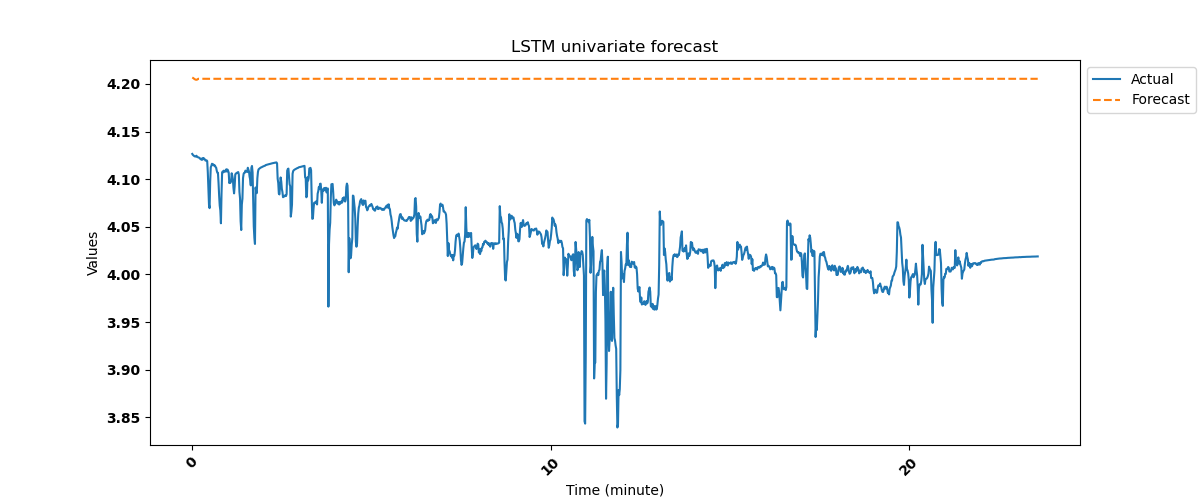

In [129]:
%matplotlib notebook
x_axis = np.arange(lstm_uni.shape[0])
y = y[:FORECAST_SECONDS]

save_path = os.path.join(cwd, 'lstm_univar_window10', 'model' + str(iteration_no) + '.pdf')
custom_plot.plot_multi_line(("LSTM univariate forecast", save_path, "Values"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (lstm_uni, "Forecast"))